In [1]:
import pandas as pd
import numpy as np
import unicodedata 
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import CellIsRule
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
import matplotlib.pyplot as plt
import libpysal
from esda.moran import Moran_BV
from splot.esda import moran_scatterplot
import pandas as pd
import numpy as np
import os
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.utils import get_column_letter
import geopandas as gpd


## [__Consulta cand: https://dadosabertos.tse.jus.br/dataset/candidatos-2024__](https://dadosabertos.tse.jus.br/dataset/candidatos-2024)

In [2]:
# Specify the file path
file_path = r"consulta_cand_2024_MT-base de dados.xlsx"
sheet_name = "consulta_cand_2024_MT"

# Read the Excel file
cand = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the filtered DataFrame
print(cand)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO       DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13       VEREADOR   
1             1  91677          VÁRZEA GRANDE        13       VEREADOR   
2             1  91170                 NOBRES        13       VEREADOR   
3             1  91294                 POCONÉ        13       VEREADOR   
4             1  90280               CONFRESA        12  VICE-PREFEITO   
...         ...    ...                    ...       ...            ...   
11099         1  90387      NOVA BANDEIRANTES        13       VEREADOR   
11100         1  90069              QUERÊNCIA        13       VEREADOR   
11101         1  90484  CAMPO NOVO DO PARECIS        13       VEREADOR   
11102         1  89877          ALTA FLORESTA        13       VEREADOR   
11103         1  90336        BARRA DO BUGRES        13       VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO                      NM_CANDIDATO  \
0      110002111772         15444      R

In [3]:
##Total elected
print(cand['DS_SIT_TOT_TURNO'].unique())

['NÃO ELEITO' 'SUPLENTE' '#NULO' 'ELEITO POR QP' 'ELEITO'
 'ELEITO POR MÉDIA' '2º TURNO']


In [4]:
count_prefeito_eleito = len(cand[
    (cand['DS_CARGO'] == 'PREFEITO') & 
    (cand['DS_SIT_TOT_TURNO'] == 'ELEITO')
])
print(f"Total PREFEITO ELEITO: {count_prefeito_eleito}")

count_vereador_eleito = len(cand[
    (cand['DS_CARGO'] == 'VEREADOR') & 
    (cand['DS_SIT_TOT_TURNO'].isin(['ELEITO', 'ELEITO POR QP', 'ELEITO POR MÉDIA']))
])
print(f"Total VEREADOR ELEITO (including QP/MÉDIA): {count_vereador_eleito}")

Total PREFEITO ELEITO: 142
Total VEREADOR ELEITO (including QP/MÉDIA): 1406


In [5]:
cand = cand[cand['DS_SIT_TOT_TURNO'] != '2º TURNO']
print(cand)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO       DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13       VEREADOR   
1             1  91677          VÁRZEA GRANDE        13       VEREADOR   
2             1  91170                 NOBRES        13       VEREADOR   
3             1  91294                 POCONÉ        13       VEREADOR   
4             1  90280               CONFRESA        12  VICE-PREFEITO   
...         ...    ...                    ...       ...            ...   
11099         1  90387      NOVA BANDEIRANTES        13       VEREADOR   
11100         1  90069              QUERÊNCIA        13       VEREADOR   
11101         1  90484  CAMPO NOVO DO PARECIS        13       VEREADOR   
11102         1  89877          ALTA FLORESTA        13       VEREADOR   
11103         1  90336        BARRA DO BUGRES        13       VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO                      NM_CANDIDATO  \
0      110002111772         15444      R

In [6]:
##Excluding Vice-Prefeito
cand = cand[cand['DS_CARGO'] != 'VICE-PREFEITO']
print(cand)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13  VEREADOR   
1             1  91677          VÁRZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONÉ        13  VEREADOR   
5             1  98930                SORRISO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
11099         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
11100         1  90069              QUERÊNCIA        13  VEREADOR   
11101         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
11102         1  89877          ALTA FLORESTA        13  VEREADOR   
11103         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO                      NM_CANDIDATO  \
0      110002111772         15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808         2

In [7]:
def create_race_gender_tables(df, output_path='Artigo_race_gender_analysis.xlsx'):
    # Filter for Prefeito and Vereador
    df = df[df['DS_CARGO'].isin(['PREFEITO', 'VEREADOR'])]
    
    # Create count table
    count_table = pd.pivot_table(df,
                               index='DS_COR_RACA',
                               columns=['DS_CARGO', 'DS_GENERO'],
                               aggfunc='size',
                               fill_value=0)
    
    # Reorder columns to match requested format
    count_table = count_table[[('PREFEITO', 'MASCULINO'), 
                             ('PREFEITO', 'FEMININO'),
                             ('VEREADOR', 'MASCULINO'),
                             ('VEREADOR', 'FEMININO')]]
    
    # Create percentage table
    total_by_position = df.groupby('DS_CARGO').size()
    percentage_table = count_table.copy()
    
    for (position, gender) in percentage_table.columns:
        percentage_table[(position, gender)] = (percentage_table[(position, gender)] / 
                                              total_by_position[position]) * 100
    
    # Round percentages
    percentage_table = percentage_table.round(2)
    
    # Create Excel writer
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Write count table
        count_table.to_excel(writer, sheet_name='Counts')
        
        # Write percentage table
        percentage_table.to_excel(writer, sheet_name='Percentages')
        
        # Format sheets
        for sheetname in writer.sheets:
            worksheet = writer.sheets[sheetname]
            
            # Set column widths
            worksheet.column_dimensions['A'].width = 20
            for col in ['B', 'C', 'D', 'E']:
                worksheet.column_dimensions[col].width = 15
            
            # Add headers
            if sheetname == 'Counts':
                worksheet['B1'] = 'PREFEITO'
                worksheet['D1'] = 'VEREADOR'
                worksheet['B2'] = 'MASCULINO'
                worksheet['C2'] = 'FEMININO'
                worksheet['D2'] = 'MASCULINO'
                worksheet['E2'] = 'FEMININO'
            else:
                worksheet['B1'] = 'PREFEITO (%)'
                worksheet['D1'] = 'VEREADOR (%)'
                worksheet['B2'] = 'MASCULINO'
                worksheet['C2'] = 'FEMININO'
                worksheet['D2'] = 'MASCULINO'
                worksheet['E2'] = 'FEMININO'
    
    print(f"File saved successfully at: {output_path}")

# Usage example:
if 'cand' in globals():
    create_race_gender_tables(cand)
else:
    print("Please make sure your 'cand' dataframe is loaded before running this analysis.")

File saved successfully at: Artigo_race_gender_analysis.xlsx


## Aditional Information: https://dadosabertos.tse.jus.br/dataset/candidatos-2024

In [8]:
# Specify the file path
file_path2 = r"consulta_cand_2024_MT-base de dados complementar.xlsx"
sheet_name2= "consulta_cand_complementar_2024"

# Read the file with the detected encoding
cand2 = pd.read_excel(file_path2, sheet_name=sheet_name2)

# Print the column names
print("Column names:")
print(cand2.columns.tolist())

Column names:
['SQ_CANDIDATO', 'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'CD_NACIONALIDADE', 'DS_NACIONALIDADE', 'CD_MUNICIPIO_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO', 'NR_IDADE_DATA_POSSE', 'ST_QUILOMBOLA', 'CD_ETNIA_INDIGENA', 'DS_ETNIA_INDIGENA', 'VR_DESPESA_MAX_CAMPANHA', 'ST_REELEICAO', 'ST_DECLARAR_BENS', 'NR_PROTOCOLO_CANDIDATURA', 'NR_PROCESSO', 'CD_SITUACAO_CANDIDATO_PLEITO', 'DS_SITUACAO_CANDIDATO_PLEITO', 'CD_SITUACAO_CANDIDATO_URNA', 'DS_SITUACAO_CANDIDATO_URNA', 'ST_CANDIDATO_INSERIDO_URNA', 'NM_TIPO_DESTINACAO_VOTOS', 'CD_SITUACAO_CANDIDATO_TOT', 'DS_SITUACAO_CANDIDATO_TOT', 'ST_PREST_CONTAS', 'ST_SUBSTITUIDO', 'SQ_SUBSTITUIDO', 'SQ_ORDEM_SUPLENCIA', 'DT_ACEITE_CANDIDATURA', 'CD_SITUACAO_JULGAMENTO', 'DS_SITUACAO_JULGAMENTO', 'CD_SITUACAO_JULGAMENTO_PLEITO', 'DS_SITUACAO_JULGAMENTO_PLEITO', 'CD_SITUACAO_JULGAMENTO_URNA', 'DS_SITUACAO_JULGAMENTO_URNA', 'CD_SITUACAO_CASSACAO', 'DS_SITUACAO_CASSACAO', 'CD_SITUACAO_CASSACAO_MIDIA', 'DS_SITUACAO_CASSACAO_MIDIA', '

### __Merging the two cand dataframes__

In [9]:
# Merge DataFrames
cand3 = pd.merge(cand, cand2, on='SQ_CANDIDATO', how='inner')
print(cand3)

# Print the column names
print("Column names:")
print(cand3.columns.tolist())

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13  VEREADOR   
1             1  91677          VÁRZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONÉ        13  VEREADOR   
4             1  98930                SORRISO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10723         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10724         1  90069              QUERÊNCIA        13  VEREADOR   
10725         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10726         1  89877          ALTA FLORESTA        13  VEREADOR   
10727         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO                      NM_CANDIDATO  \
0      110002111772         15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808         2

## Prestação de contas: https://dadosabertos.tse.jus.br/dataset/prestacao-de-contas-eleitorais-2024. 

In [10]:
# Specify the file path
file_path3 = r"receitas_candidatos_2024_MT-base de dados.xlsx"
sheet_name3 = "receitas_candidatos_2024_MT"

# Read the file with the detected encoding
inc = pd.read_excel(file_path3, sheet_name=sheet_name3)

# Print the column names
print("Column names:")
print(inc.columns.tolist())

Column names:
['TP_PRESTACAO_CONTAS', 'DT_PRESTACAO_CONTAS', 'SQ_PRESTADOR_CONTAS', 'SG_UF', 'SG_UE', 'NM_UE', 'NR_CNPJ_PRESTADOR_CONTA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NR_CPF_CANDIDATO', 'NR_CPF_VICE_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO', 'CD_FONTE_RECEITA', 'DS_FONTE_RECEITA', 'CD_ORIGEM_RECEITA', 'DS_ORIGEM_RECEITA', 'CD_NATUREZA_RECEITA', 'DS_NATUREZA_RECEITA', 'CD_ESPECIE_RECEITA', 'DS_ESPECIE_RECEITA', 'CD_CNAE_DOADOR', 'DS_CNAE_DOADOR', 'NR_CPF_CNPJ_DOADOR', 'NM_DOADOR', 'NM_DOADOR_RFB', 'CD_ESFERA_PARTIDARIA_DOADOR', 'DS_ESFERA_PARTIDARIA_DOADOR', 'SG_UF_DOADOR', 'CD_MUNICIPIO_DOADOR', 'NM_MUNICIPIO_DOADOR', 'SQ_CANDIDATO_DOADOR', 'NR_CANDIDATO_DOADOR', 'CD_CARGO_CANDIDATO_DOADOR', 'DS_CARGO_CANDIDATO_DOADOR', 'NR_PARTIDO_DOADOR', 'SG_PARTIDO_DOADOR', 'NM_PARTIDO_DOADOR', 'NR_RECIBO_DOACAO', 'NR_DOCUMENTO_DOACAO', 'SQ_RECEITA', 'DT_RECEITA', 'DS_RECEITA', 'VR_RECEITA', 'DS_NATUREZA_RECURSO_ESTIMAVEL', 'DS_GENERO', 'DS_COR

In [11]:
# Creating the pivot table with additional columns
inc2 = inc.pivot_table(
    values='VR_RECEITA', 
    index=['NM_CANDIDATO', 'NR_CANDIDATO', 'NR_PARTIDO', 'NM_PARTIDO', 'DS_GENERO', 'DS_COR_RACA'],  # Include all columns to preserve
    columns='DS_FONTE_RECEITA', 
    aggfunc='sum', 
    fill_value=0
)

# Resetting the index to turn all index columns back into regular columns
inc2 = inc2.reset_index()

# Renaming the columns to remove the index column name
inc2.columns.name = None

print(inc2)

                         NM_CANDIDATO  NR_CANDIDATO  NR_PARTIDO  \
0                      0314 1199 1813         44222          44   
1                           78875-000         10123          10   
2              ABADIA DE MOURA MORAES         10678          10   
3              ABDIAS VIEIRA DA SILVA         44111          44   
4                   ABENEL COSTA MELO         40440          40   
...                               ...           ...         ...   
10507             ÉRICO GERALDES CRUZ         15678          15   
10508  ÉRIKA LORRAYNE DA COSTA SARATE         10852          10   
10509            ÉSDA LOPES DE FARIAS         44222          44   
10510       ÉSSIONE BARRETO DE ARAÚJO         40555          40   
10511        ÉVERTON NEVES DOS SANTOS         55125          55   

                             NM_PARTIDO  DS_GENERO DS_COR_RACA  #NULO  \
0                          União Brasil   Feminino       Parda    0.0   
1                          REPUBLICANOS  Masculin

## __Combine two datasets: inc2 and cand3__

In [12]:
# Create clean versions for merging
cand3['clean_name'] = (
    cand3['NM_CANDIDATO']
    .str.upper()
    .str.normalize('NFKD')  # Normalize accents
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.strip()
)

inc2['clean_name'] = (
    inc2['NM_CANDIDATO']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.strip()
)

In [13]:
# Perform the left merge on 'clean_name'
merged_df = cand3.merge(
    inc2,
    how='inner',
    on='clean_name',
    suffixes=('_cand', '_inc')  # Optional: to distinguish columns from each source
)

# Check the result
print(merged_df)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13  VEREADOR   
1             1  91677          VÁRZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONÉ        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERÊNCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [14]:
inc2 = merged_df 
print(merged_df )

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13  VEREADOR   
1             1  91677          VÁRZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONÉ        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERÊNCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

### Logarithimic transformation of incomes

In [15]:
# Apply logarithmic transformation to the specified columns
inc2['FUNDO ESPECIAL'] = np.log(inc2['FUNDO ESPECIAL']) 
inc2['FUNDO PARTIDARIO'] = np.log(inc2['FUNDO PARTIDARIO'])  
inc2['OUTROS RECURSOS'] = np.log(inc2['OUTROS RECURSOS'])  

# Replace inf and nan with zero
inc2 = inc2.replace([np.inf, -np.inf, np.nan], 0)

# Display the updated DataFrame
print(inc2)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARÇAS        13  VEREADOR   
1             1  91677          VÁRZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONÉ        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERÊNCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

c:\Users\daves\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Cleaning dataframe

In [16]:
# Drop rows where 'DS_SIT_TOT_TURNO' is NaN or '#NULO'
inc2_cleaned = inc2.dropna(subset=['DS_SIT_TOT_TURNO'])  # Drop NaN
inc2_cleaned = inc2_cleaned[inc2_cleaned['DS_SIT_TOT_TURNO'] != '#NULO']  # Drop '#NULO'

# Function to normalize text - removes accents but keeps base letters
def normalize_text(text):
    # Normalize Unicode characters (NFD separates base characters from accents)
    normalized = unicodedata.normalize('NFD', text)
    # Remove diacritical marks (accents)
    normalized = ''.join([c for c in normalized if not unicodedata.combining(c)])
    # Remove specific symbols
    normalized = normalized.replace("'", "").replace(",", "").replace("~", "")
    return normalized

# Apply the normalization function
inc2_cleaned['NM_UE'] = inc2_cleaned['NM_UE'].apply(normalize_text)

# Print unique values in the NM_UE column
print(inc2_cleaned['NM_UE'].unique())

# Print the cleaned DataFrame
print(inc2_cleaned)
print(inc2_cleaned.columns)

['BARRA DO GARCAS' 'VARZEA GRANDE' 'NOBRES' 'POCONE' 'DIAMANTINO'
 'BARRA DO BUGRES' 'PONTES E LACERDA' 'ALTO PARAGUAI' 'CACERES'
 'NOVA BANDEIRANTES' 'NORTELANDIA' 'CANARANA' 'NOVA MUTUM'
 'SAO JOSE DO XINGU' 'APIACAS' 'NOVA MONTE VERDE' 'RIBEIRAO CASCALHEIRA'
 'PARANATINGA' 'PORTO DOS GAUCHOS' 'CAMPO VERDE' 'VALE DE SAO DOMINGOS'
 'ARAGUAIANA' 'JAURU' 'BRASNORTE' 'POXOREU' 'MIRASSOL DOESTE'
 'UNIAO DO SUL' 'NOVO HORIZONTE DO NORTE' 'RONDONOPOLIS'
 'SANTO ANTONIO DO LEVERGER' 'VERA' 'PRIMAVERA DO LESTE' 'COCALINHO'
 'CARLINDA' 'NOVA CANAA DO NORTE' 'CURVELANDIA' 'JURUENA' 'DENISE'
 'ARENAPOLIS' 'NOVA XAVANTINA' 'FELIZ NATAL' 'PORTO ESPERIDIAO' 'COLNIZA'
 'DOM AQUINO' 'NOVO MUNDO' 'ARAPUTANGA' 'PONTAL DO ARAGUAIA' 'LUCIARA'
 'INDIAVAI' 'JUARA' 'CLAUDIA' 'CAMPINAPOLIS' 'GENERAL CARNEIRO'
 'NOVO SANTO ANTONIO' 'CONFRESA' 'ALTA FLORESTA' 'CHAPADA DOS GUIMARAES'
 'ARAGUAINHA' 'JUINA' 'SAO JOSE DO POVO' 'RIO BRANCO' 'NOVA GUARITA'
 'SINOP' 'PEDRA PRETA' 'NOSSA SENHORA DO LIVRAMENTO' 'GLORIA

### Generating dummies

In [17]:
# Create the dummy variable 'ELEITO'
inc2_cleaned['ELEITO'] = inc2_cleaned['DS_SIT_TOT_TURNO'].isin(['ELEITO POR MÉDIA', 'ELEITO', 'ELEITO POR QP']).astype(int)

# Print the updated DataFrame
print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [18]:
# DS_COR_RACA
unique_values = inc2_cleaned['DS_COR_RACA_inc'].unique()

# Print the unique values
print(unique_values)

#Correcting speeling
inc2_cleaned['DS_COR_RACA'] = inc2_cleaned['DS_COR_RACA_inc']

['Parda' 'Preta' 'Branca' 'Indígena' 'Amarela' 'Sem Informação']


In [19]:
# Create the dummy variable 'BRANCA', 'PRETA', 'PARDA', 'INDÍGENA" and "AMARELA"
inc2_cleaned['BRANCA'] = inc2_cleaned['DS_COR_RACA'].isin(['Branca']).astype(int)
inc2_cleaned['PRETA'] = inc2_cleaned['DS_COR_RACA'].isin(['Preta']).astype(int)
inc2_cleaned['PARDA'] = inc2_cleaned['DS_COR_RACA'].isin(['Parda']).astype(int)
inc2_cleaned['INDÍGENA'] = inc2_cleaned['DS_COR_RACA'].isin(['Indígena']).astype(int)
inc2_cleaned['AMARELA'] = inc2_cleaned['DS_COR_RACA'].isin(['Amarela']).astype(int)

# Drop rows where 'DS_COR_RACA' is 'Sem Informação'
inc2_cleaned = inc2_cleaned[inc2_cleaned['DS_COR_RACA'] != 'Sem Informação']

# Print the updated DataFrame
print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [20]:
#Correcting speeling
inc2_cleaned['DS_GENERO'] = inc2_cleaned['DS_GENERO_inc']

# Create the dummy variables for gender
inc2_cleaned['FEMININO'] = inc2_cleaned['DS_GENERO'].isin(['Feminino']).astype(int)
inc2_cleaned['MASCULINO'] = inc2_cleaned['DS_GENERO'].isin(['Masculino']).astype(int)

# Print the updated DataFrame
print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [21]:
# Reelection status
unique_values = inc2_cleaned['ST_REELEICAO'].unique()

# Print the unique values
print(unique_values)

['N' 'S']


In [22]:
# Create the dummy variable for reelection
inc2_cleaned['REELEIÇÃO'] = inc2_cleaned['ST_REELEICAO'].isin(['S']).astype(int)

# Print the updated DataFrame
print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [23]:
#Correcting speeling
inc2_cleaned['NM_PARTIDO'] = inc2_cleaned['NM_PARTIDO_inc']

# Party names
unique_values = inc2_cleaned['NM_PARTIDO'].unique()

# Print the unique values
print(unique_values)

['Movimento Democrático Brasileiro' 'Democracia Cristã' 'Podemos'
 'Partido dos Trabalhadores' 'Partido da Mulher Brasileira'
 'Partido Renovação Democrática' 'Partido Socialista Brasileiro'
 'PROGRESSISTAS' 'União Brasil' 'Partido Renovador Trabalhista Brasileiro'
 'Partido Social Democrático' 'REPUBLICANOS' 'Partido Liberal'
 'Partido Novo' 'Partido Democrático Trabalhista' 'Solidariedade' 'AGIR'
 'Cidadania' 'Partido da Social Democracia Brasileira'
 'Rede Sustentabilidade' 'Partido Verde' 'Partido Socialismo e Liberdade'
 'Partido Comunista do Brasil']


In [24]:
## Governador dummy - for each party in 2022 election

# List of parties that should have GOVERNADOR = 1
parties2 = ['União Brasil', 'Partido Socialista Brasileiro', 
           'Cidadania', 'Movimento Democrático Brasileiro', 
           'Partido da Social Democracia Brasileira', 'Podemos']

# Create the GOVERNADOR variable
inc2_cleaned['GOVERNADOR'] = inc2_cleaned['NM_PARTIDO'].apply(lambda x: 1 if x in parties2 else 0)

print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [25]:
## Presidente dummy - for each party in 2022 election

# List of parties that should have Presidente = 1
parties3 = ['REPUBLICANOS', 'PROGRESSISTAS', 
           'Partido Liberal']

# Create the GOVERNADOR variable
inc2_cleaned['PRESIDENTE'] = inc2_cleaned['NM_PARTIDO'].apply(lambda x: 1 if x in parties3 else 0)

print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

In [26]:
# Create dummy variables for DS_GRAU_INSTRUCAO
dummies_instrucao = pd.get_dummies(inc2_cleaned['DS_GRAU_INSTRUCAO'], prefix='INSTRUCAO')

# Create dummy variables for DS_ESTADO_CIVIL
dummies_estado_civil = pd.get_dummies(inc2_cleaned['DS_ESTADO_CIVIL'], prefix='ESTADO_CIVIL')

# Concatenate the dummy variables with the original DataFrame
inc2_cleaned = pd.concat([inc2_cleaned, dummies_instrucao, dummies_estado_civil], axis=1)

# Drop the original columns if you no longer need them
inc2_cleaned = inc2_cleaned.drop(['DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL'], axis=1)

print(inc2_cleaned)

       NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0             1  90352        BARRA DO GARCAS        13  VEREADOR   
1             1  91677          VARZEA GRANDE        13  VEREADOR   
2             1  91170                 NOBRES        13  VEREADOR   
3             1  91294                 POCONE        13  VEREADOR   
4             1  90697             DIAMANTINO        13  VEREADOR   
...         ...    ...                    ...       ...       ...   
10266         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
10267         1  90069              QUERENCIA        13  VEREADOR   
10268         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
10269         1  89877          ALTA FLORESTA        13  VEREADOR   
10270         1  90336        BARRA DO BUGRES        13  VEREADOR   

       SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0      110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1      110002021808

## Economic variables

### Income from municipalities

In [27]:
## As cities' GDP is not available, use the total revenue from each town
# 2024 values
file_path_rev24 = r"Radar/radar_de_controle_público_-_módulo_receita_-_receita_por_jurisdicionado_2024.xlsx"
sheet_name_rev24 = "radar_de_controle_público_-_mód"

# Read the file with the detected encoding
rev24 = pd.read_excel(file_path_rev24, sheet_name=sheet_name_rev24)

# Print the column names
print("Column names:")
print(rev24.columns.tolist())

Column names:
['Jurisdicionado', 'Receita Prevista', 'Receita Arrecadada']


In [28]:
# 2023 values
file_path_rev23 = r"Radar\radar_de_controle_público_-_módulo_receita_-_receita_por_jurisdicionado_2023.xlsx"
sheet_name_rev23 = "radar_de_controle_público_-_mód"

# Read the file with the detected encoding
rev23 = pd.read_excel(file_path_rev23, sheet_name=sheet_name_rev23)

# Print the column names
print("Column names:")
print(rev23.columns.tolist())

Column names:
['Jurisdicionado', 'Receita Prevista', 'Receita Arrecadada']


In [29]:
# Merge the DataFrames
merged_df = pd.merge(rev24, rev23, on='Jurisdicionado', suffixes=('_2024', '_2023'))
# Calculate the change from 2023 to 2024
merged_df['Incremento'] = (merged_df['Receita Arrecadada_2024'] - merged_df['Receita Arrecadada_2023'])

# Create the new DataFrame 'revenue'
revenue = merged_df[['Jurisdicionado', 'Receita Arrecadada_2024', 'Incremento']]

# Rename columns for clarity
revenue.columns = ['Jurisdicionado', 'Receita Arrecadada', 'Incremento']

# Remove "PREFEITURA MUNICIPAL DE" from the Jurisdicionado column
revenue['Jurisdicionado'] = revenue['Jurisdicionado'].str.replace('PREFEITURA MUNICIPAL DE ', '')

# Print the resulting DataFrame
print(revenue.head())

  Jurisdicionado  Receita Arrecadada    Incremento
0         CUIABA        2.891761e+09 -1.505771e+08
1   RONDONOPOLIS        1.238428e+09 -2.297870e+08
2  VARZEA GRANDE        0.000000e+00 -1.138983e+09
3          SINOP        1.142775e+09  1.894999e+08
4        SORRISO        7.885314e+08  5.307208e+07


C:\Users\daves\AppData\Local\Temp\ipykernel_21520\2341734216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue['Jurisdicionado'] = revenue['Jurisdicionado'].str.replace('PREFEITURA MUNICIPAL DE ', '')


In [30]:
##Merging inc2_cleaned with revenue
##Várzea Grande does not have such data

# Rename columns in revenue dataframe
revenue = revenue.rename(columns={
    'Receita Arrecadada': 'RECEITA MUNICIPAL',
    'Incremento': 'INCREMENTO EM RECEITAS MUNICIPAIS'
})

# Merge revenue with inc2_cleaned and keep the name inc2_cleaned
inc2_cleaned = pd.merge(
    inc2_cleaned,
    revenue,
    left_on='NM_UE',
    right_on='Jurisdicionado',
    how='left'  # Keep all rows from inc2_cleaned
)

# Drop the redundant 'Jurisdicionado' column and other specified columns
inc2_cleaned = inc2_cleaned.drop(columns=[
    'Jurisdicionado_x', 
    'Jurisdicionado_y'
    'RECEITA MUNICIPAL_x',
    'INCREMENTO EM RECEITAS MUNICIPAIS_x',
    'RECEITA MUNICIPAL_y',
    'INCREMENTO EM RECEITAS MUNICIPAIS_y',
    'RECEITA'
], errors='ignore')

# Add logarithmic transformation of RECEITA MUNICIPAL while keeping the original column
# Replace NaN values in RECEITA MUNICIPAL with 0
inc2_cleaned['RECEITA MUNICIPAL'] = inc2_cleaned['RECEITA MUNICIPAL'].fillna(0)

# Replace NaN values in INCREMENTO EM RECEITAS MUNICIPAIS with 0
inc2_cleaned['INCREMENTO EM RECEITAS MUNICIPAIS'] = inc2_cleaned['INCREMENTO EM RECEITAS MUNICIPAIS'].fillna(0)

# Create a new column for the logarithmic transformation
# For places like Várzea Grande with missing or zero values, set log to zero
inc2_cleaned['LOG_RECEITA_MUNICIPAL'] = 0  # First set all to zero
# Then calculate log only for rows with positive values
mask = inc2_cleaned['RECEITA MUNICIPAL'] > 0
inc2_cleaned.loc[mask, 'LOG_RECEITA_MUNICIPAL'] = np.log1p(inc2_cleaned.loc[mask, 'RECEITA MUNICIPAL'])

# Create a new column for the logarithmic transformation
# For places like Várzea Grande with missing or zero values, set log to zero
inc2_cleaned['LOG_INCREMENTO'] = 0  # First set all to zero
# Then calculate log only for rows with positive values
mask = inc2_cleaned['INCREMENTO EM RECEITAS MUNICIPAIS'] > 0
inc2_cleaned.loc[mask, 'LOG_INCREMENTO'] = np.log1p(inc2_cleaned.loc[mask, 'INCREMENTO EM RECEITAS MUNICIPAIS'])

# Print the first few rows of the merged dataframe
print(inc2_cleaned.head())

   NR_TURNO  SG_UE            NM_UE  CD_CARGO  DS_CARGO  SQ_CANDIDATO  \
0         1  90352  BARRA DO GARCAS        13  VEREADOR  110002111772   
1         1  91677    VARZEA GRANDE        13  VEREADOR  110002021808   
2         1  91170           NOBRES        13  VEREADOR  110002141596   
3         1  91294           POCONE        13  VEREADOR  110002323484   
4         1  90697       DIAMANTINO        13  VEREADOR  110002334388   

   NR_CANDIDATO_cand                 NM_CANDIDATO_cand      NM_URNA_CANDIDATO  \
0              15444      RAIMUNDO RIBEIRO DE OLIVEIRA            RAIMUNDINHO   
1              27027  APARECIDA BENTINHA DE FIGUEIREDO        CYDA FIGUEIREDO   
2              20333           NELSON PEREIRA DA SILVA  NEGÃO CHI BOM BOM BOM   
3              13007   EDELSON MARIO DE CAMPOS E SILVA                 MARIO    
4              35559              NEDIR JOSE GONÇALVES        NEDIR GONÇALVES   

  NM_SOCIAL_CANDIDATO  ...  ESTADO_CIVIL_CASADO(A) ESTADO_CIVIL_DIVORCIADO

C:\Users\daves\AppData\Local\Temp\ipykernel_21520\2553791635.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19.67427724 18.68936239 19.02981418 ... 19.73323006 19.53166469
 19.34929661]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  inc2_cleaned.loc[mask, 'LOG_RECEITA_MUNICIPAL'] = np.log1p(inc2_cleaned.loc[mask, 'RECEITA MUNICIPAL'])
C:\Users\daves\AppData\Local\Temp\ipykernel_21520\2553791635.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.45195602 16.64177927 16.82283424 ... 17.07388867 16.19476943
 18.01156336]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  inc2_cleaned.loc[mask, 'LOG_INCREMENTO'] = np.log1p(inc2_cleaned.loc[mask, 'INCREMENTO EM RECEITAS MUNICIPAIS'])


### Expenditures on education and health/social assistance from january to september 2024 (month before the elections)

### Education

In [31]:
# Education
file_path_ed = r"Radar\radar_de_controle_público_-_módulo_despesas_-_despesas_por_jurisdicionado_2024_educação.xlsx"
sheet_name_ed = "radar_de_controle_público_-_mód"

# Read the file with the detected encoding
ed = pd.read_excel(file_path_ed, sheet_name=sheet_name_ed)

# Print the column names
print("Column names:")
print(ed.columns.tolist())

Column names:
['Jurisdicionado', 'Empenhado', 'Liquidado', 'Pago/Retido']


In [32]:
# Remove the prefix 'PREFEITURA MUNICIPAL DE ' from the 'Jurisdicionado' column
ed['Jurisdicionado'] = ed['Jurisdicionado'].str.replace('PREFEITURA MUNICIPAL DE ', '')

# Drop rows where 'Jurisdicionado' contains 'FUNDO UNICO MUNICIPAL DE EDUCACAO DE'
ed = ed[~ed['Jurisdicionado'].str.contains('FUNDO UNICO MUNICIPAL DE EDUCACAO DE', case=False, na=False)]

unique_values = ed['Jurisdicionado'].unique()
print(unique_values)

['RONDONOPOLIS' 'SINOP' 'SORRISO' 'LUCAS DO RIO VERDE'
 'PRIMAVERA DO LESTE' 'TANGARA DA SERRA' 'NOVA MUTUM' 'CACERES'
 'CAMPO NOVO DO PARECIS' 'CAMPO VERDE' 'BARRA DO GARCAS' 'SAPEZAL'
 'AGUA BOA' 'ALTA FLORESTA' 'PONTES E LACERDA' 'GUARANTA DO NORTE'
 'CANARANA' 'CONFRESA' 'JUINA' 'QUERENCIA' 'ARIPUANA' 'DIAMANTINO'
 'PEIXOTO DE AZEVEDO' 'JUARA' 'POCONE' 'PARANATINGA' 'BARRA DO BUGRES'
 'VILA RICA' 'COLNIZA' 'ALTO ARAGUAIA' 'COLIDER' 'NOVA UBIRATA' 'JACIARA'
 'COMODORO' 'CAMPINAPOLIS' 'MATUPA' 'PEDRA PRETA' 'MIRASSOL DOESTE'
 'VILA BELA DA SANTISSIMA TRINDADE' 'CAMPOS DE JULIO' 'NOVA XAVANTINA'
 'BRASNORTE' 'CHAPADA DOS GUIMARAES' 'ITIQUIRA' 'SAO JOSE DO RIO CLARO'
 'RONDOLANDIA' 'VERA' 'SAO FELIX DO ARAGUAIA' 'NOVA OLIMPIA' 'TABAPORA'
 'ROSARIO OESTE' 'GAUCHA DO NORTE' 'PARANAITA'
 'NOSSA SENHORA DO LIVRAMENTO' 'MARCELANDIA' 'SANTO ANTONIO DO LEVERGER'
 'NOBRES' 'POXOREU' 'NOVA BANDEIRANTES' 'NOVA CANAA DO NORTE'
 'SAO JOSE DOS QUATRO MARCOS' 'ARAPUTANGA' 'ALTO TAQUARI' 'FELIZ NATAL

In [33]:
# Drop 'Empenhado' and 'Pago/Retido' columns
ed = ed.drop(columns=['Empenhado', 'Pago/Retido'])

# Replace NaN, inf, or missing values in 'Liquidado' with zeros
ed['Liquidado'] = ed['Liquidado'].replace([np.nan, np.inf, -np.inf], 0)

# Create a new column 'LOG_EDUCATION' with the logarithm of 'Liquidado'
# Set log(0) to 0 instead of replacing 0 with 1
ed['LOG_EDUCAÇÃO'] = np.where(ed['Liquidado'] > 0, np.log(ed['Liquidado']), 0)

# Display the resulting DataFrame
print(ed)

         Jurisdicionado     Liquidado  LOG_EDUCAÇÃO
1          RONDONOPOLIS  2.917736e+08     19.491489
2                 SINOP  2.332699e+08     19.267707
3               SORRISO  1.989296e+08     19.108462
4    LUCAS DO RIO VERDE  1.440767e+08     18.785856
5    PRIMAVERA DO LESTE  1.222430e+08     18.621521
..                  ...           ...           ...
135             TESOURO  4.698335e+06     15.362719
136  RESERVA DO CABACAL  4.345063e+06     15.284551
137        PONTE BRANCA  4.590125e+06     15.339418
138             LUCIARA  4.367265e+06     15.289648
139          ARAGUAINHA  2.206342e+06     14.606847

[139 rows x 3 columns]


In [34]:
# Merge the LOG_EDUCATION column from ed dataframe into inc2_cleaned
inc2_cleaned = inc2_cleaned.merge(
    ed[['Jurisdicionado', 'LOG_EDUCAÇÃO']], 
    on='Jurisdicionado', 
    how='left'
)

# Replace NaNs with 0 in the column 'LOG_EDUCATION'
inc2_cleaned['LOG_EDUCAÇÃO'] = inc2_cleaned['LOG_EDUCAÇÃO'].fillna(0)

print(inc2_cleaned)

      NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0            1  90352        BARRA DO GARCAS        13  VEREADOR   
1            1  91677          VARZEA GRANDE        13  VEREADOR   
2            1  91170                 NOBRES        13  VEREADOR   
3            1  91294                 POCONE        13  VEREADOR   
4            1  90697             DIAMANTINO        13  VEREADOR   
...        ...    ...                    ...       ...       ...   
9534         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
9535         1  90069              QUERENCIA        13  VEREADOR   
9536         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
9537         1  89877          ALTA FLORESTA        13  VEREADOR   
9538         1  90336        BARRA DO BUGRES        13  VEREADOR   

      SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0     110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1     110002021808              2

#### Health and social assistance

In [35]:
# Health and social assistance
file_path_health = r"Radar\radar_de_controle_público_-_módulo_despesas_-_despesas_por_jurisdicionado_2024_saúde e assistência social.xlsx"
sheet_name_health = "radar_de_controle_público_-_mód"

# Read the file with the detected encoding
health = pd.read_excel(file_path_health, sheet_name=sheet_name_health)

# Print the column names
print("Column names:")
print(health.columns.tolist())

Column names:
['Jurisdicionado', 'Empenhado', 'Liquidado', 'Pago/Retido']


In [36]:
# Remove the prefix 'PREFEITURA MUNICIPAL DE ' from the 'Jurisdicionado' column
health['Jurisdicionado'] = health['Jurisdicionado'].str.replace('PREFEITURA MUNICIPAL DE ', '')

# Drop specific observations due to services made to public servants
observations_to_drop = [
    "INSTITUTO DE ASSISTENCIA A SAUDE DOS SERVIDORES PUBLICOS MUNICIPAIS DE RONDONOPOLIS",
    "INSTITUTO MUNICIPAL DE PREVIDENCIA SOCIAL DOS SERVIDORES DE RONDONOPOLIS"
]
health = health[~health['Jurisdicionado'].isin(observations_to_drop)]

# Replace specific values to merge with cities' names
replacements = {
    'FUNDACAO MUNICIPAL DE SAUDE PREFEITO SAMUEL GREVE - MIRASSOL DOESTE': 'MIRASSOL DOESTE',
    'FUNDACAO HOSPITALAR DE SAUDE MUNICIPAL DE ITAUBA': 'ITAUBA',
    'EMPRESA CUIABANA DE SAUDE PUBLICA': 'CUIABA'
}
health['Jurisdicionado'] = health['Jurisdicionado'].replace(replacements)

# Group by 'Jurisdicionado' and sum 'Empenhado', 'Liquidado', and 'Pago/Retido'
health= health.groupby('Jurisdicionado', as_index=False).agg({
    'Empenhado': 'sum',
    'Liquidado': 'sum',
    'Pago/Retido': 'sum'
})

print(health)

                       Jurisdicionado    Empenhado    Liquidado  Pago/Retido
0                            ACORIZAL   7574119.19   7572598.67   6889496.46
1                            AGUA BOA  83994308.49  67102871.83  66432248.15
2                       ALTA FLORESTA  65098074.47  58316492.58  56728657.69
3                       ALTO ARAGUAIA  59852259.30  44544593.35  40133940.08
4                      ALTO BOA VISTA  12061715.97  11278895.84  10915677.03
..                                ...          ...          ...          ...
134                      UNIAO DO SUL   8468602.55   7888016.97   7764498.54
135              VALE DE SAO DOMINGOS   6908406.62   6706890.46   6453502.82
136                              VERA  22221987.27  18863959.21  18100857.39
137  VILA BELA DA SANTISSIMA TRINDADE  28545605.58  23100537.03  22218242.20
138                         VILA RICA  26680796.66  23665102.81  23227263.16

[139 rows x 4 columns]


In [37]:
# Drop 'Empenhado' and 'Pago/Retido' columns
health = health.drop(columns=['Empenhado', 'Pago/Retido'])

# Replace NaN, inf, or missing values in 'Liquidado' with zeros
health['Liquidado'] = health['Liquidado'].replace([np.nan, np.inf, -np.inf], 0)

# Create a new column 'LOG_HEALTH_SOCIALASSISTANCE' with the logarithm of 'Liquidado'
# Set log(0) to 0 instead of replacing 0 with 1
health['LOG_SAUDE_ASSIST_SOCIAL'] = np.where(ed['Liquidado'] > 0, np.log(ed['Liquidado']), 0)

# Display the resulting DataFrame
print(health)

                       Jurisdicionado    Liquidado  LOG_SAUDE_ASSIST_SOCIAL
0                            ACORIZAL   7572598.67                19.491489
1                            AGUA BOA  67102871.83                19.267707
2                       ALTA FLORESTA  58316492.58                19.108462
3                       ALTO ARAGUAIA  44544593.35                18.785856
4                      ALTO BOA VISTA  11278895.84                18.621521
..                                ...          ...                      ...
134                      UNIAO DO SUL   7888016.97                15.362719
135              VALE DE SAO DOMINGOS   6706890.46                15.284551
136                              VERA  18863959.21                15.339418
137  VILA BELA DA SANTISSIMA TRINDADE  23100537.03                15.289648
138                         VILA RICA  23665102.81                14.606847

[139 rows x 3 columns]


In [38]:
# Merge the LOG_HEALTH_SOCIALASSISTANCE column from ed dataframe into inc2_cleaned
inc2_cleaned = inc2_cleaned.merge(
    health[['Jurisdicionado', 'LOG_SAUDE_ASSIST_SOCIAL']], 
    on='Jurisdicionado', 
    how='left'
)

# Replace NaNs with 0 in the column 'LOG_HEALTH_SOCIALASSISTANCE'
inc2_cleaned['LOG_SAUDE_ASSIST_SOCIAL'] = inc2_cleaned['LOG_SAUDE_ASSIST_SOCIAL'].fillna(0)

print(inc2_cleaned)

      NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0            1  90352        BARRA DO GARCAS        13  VEREADOR   
1            1  91677          VARZEA GRANDE        13  VEREADOR   
2            1  91170                 NOBRES        13  VEREADOR   
3            1  91294                 POCONE        13  VEREADOR   
4            1  90697             DIAMANTINO        13  VEREADOR   
...        ...    ...                    ...       ...       ...   
9534         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
9535         1  90069              QUERENCIA        13  VEREADOR   
9536         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
9537         1  89877          ALTA FLORESTA        13  VEREADOR   
9538         1  90336        BARRA DO BUGRES        13  VEREADOR   

      SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0     110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1     110002021808              2

## Final Dataframe

In [39]:
# Create inc3 by dropping specified columns from inc2_cleaned
inc3 = inc2_cleaned

# Rename the education columns by removing 'INSTRUCAO_' prefix
education_cols = [
    'INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO',
    'INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
    'INSTRUCAO_ENSINO MÉDIO COMPLETO',
    'INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
    'INSTRUCAO_LÊ E ESCREVE',
    'INSTRUCAO_SUPERIOR COMPLETO',
    'INSTRUCAO_SUPERIOR INCOMPLETO'
]

# Rename the marital status columns by removing 'ESTADO_CIVIL_' prefix
marital_cols = [
    'ESTADO_CIVIL_CASADO(A)',
    'ESTADO_CIVIL_DIVORCIADO(A)',
    'ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE',
    'ESTADO_CIVIL_SOLTEIRO(A)',
    'ESTADO_CIVIL_VIÚVO(A)'
]

# Create a dictionary for renaming columns
rename_dict = {}

# Add education columns to rename dictionary
for col in education_cols:
    if col in inc3.columns:
        rename_dict[col] = col.replace('INSTRUCAO_', '')

# Add marital status columns to rename dictionary
for col in marital_cols:
    if col in inc3.columns:
        rename_dict[col] = col.replace('ESTADO_CIVIL_', '')

# Apply the renaming
inc3 = inc3.rename(columns=rename_dict)

In [40]:
# Seet 'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL' and 'LOG_INCREMENTO' to zero to non reelection
inc3.loc[inc3['REELEIÇÃO'] == 0, ['LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL', 'LOG_INCREMENTO']] = 0

In [41]:
# List of columns to convert to float
columns_to_convert = ['NM_CANDIDATO', 'NR_CANDIDATO', 'NR_PARTIDO', 'NM_PARTIDO', 'DS_GENERO',
       'DS_COR_RACA', 'FUNDO ESPECIAL',  'OUTROS RECURSOS',
       'ST_REELEICAO', 'NM_UE', 'ELEITO', 'BRANCA', 'PETRA', 'PARDA',
       'INDÍGENA', 'AMARELA', 'FEMININO', 'MASCULINO', 'REELEIÇÃO',
       'REPUBLICANOS', 'Partido Socialista Brasileiro', 'PROGRESSISTAS',
       'Partido Social Democrático', 'Partido Liberal', 'Democracia Cristã',
       'Movimento Democrático Brasileiro',
       'Partido da Social Democracia Brasileira',
       'Partido Renovação Democrática', 'Podemos', 'AGIR',
       'Partido dos Trabalhadores', 'Partido Renovador Trabalhista Brasileiro',
       'Cidadania', 'Solidariedade', 'Partido Democrático Trabalhista',
       'Partido Novo', 'Rede Sustentabilidade', 'Partido Verde',
       'Partido da Mulher Brasileira', 'Partido Comunista do Brasil',
       'Partido Socialismo e Liberdade', 'GOVERNADOR', 'INSTRUCAO_ANALFABETO',
       'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO',
       'ENSINO MÉDIO COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE',
       'SUPERIOR COMPLETO', 'SUPERIOR INCOMPLETO', 'CASADO(A)',
       'DIVORCIADO(A)', 'SEPARADO(A) JUDICIALMENTE', 'SOLTEIRO(A)', 'VIÚVO(A)',
       'Jurisdicionado_x', 'RECEITA MUNICIPAL',
       'INCREMENTO EM RECEITAS MUNICIPAIS', 'LOG_RECEITA_MUNICIPAL',
       'LOG_INCREMENTO', 'Jurisdicionado_y', 'Jurisdicionado', 'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL', 'NEGRA_PARDA']

# Convert each column to float if it exists in the dataframe
for col in columns_to_convert:
    if col in inc3.columns:
        # Check if the column is boolean type
        if inc3[col].dtype == 'bool':
            # Convert boolean to float64
            inc3[col] = inc3[col].astype('float64')
        else:
            # For non-boolean columns, try to convert to float
            try:
                inc3[col] = inc3[col].astype('float64')
            except Exception as e:
                print(f"Error converting {col} to float64: {e}")
                # Skip columns that can't be converted

Error converting NM_PARTIDO to float64: could not convert string to float: 'Movimento Democrático Brasileiro'
Error converting DS_GENERO to float64: could not convert string to float: 'Masculino'
Error converting DS_COR_RACA to float64: could not convert string to float: 'Parda'
Error converting ST_REELEICAO to float64: could not convert string to float: 'N'
Error converting NM_UE to float64: could not convert string to float: 'BARRA DO GARCAS'
Error converting Jurisdicionado to float64: could not convert string to float: 'BARRA DO GARCAS'


In [42]:
print(inc3)
print(inc3.columns)

      NR_TURNO  SG_UE                  NM_UE  CD_CARGO  DS_CARGO  \
0            1  90352        BARRA DO GARCAS        13  VEREADOR   
1            1  91677          VARZEA GRANDE        13  VEREADOR   
2            1  91170                 NOBRES        13  VEREADOR   
3            1  91294                 POCONE        13  VEREADOR   
4            1  90697             DIAMANTINO        13  VEREADOR   
...        ...    ...                    ...       ...       ...   
9534         1  90387      NOVA BANDEIRANTES        13  VEREADOR   
9535         1  90069              QUERENCIA        13  VEREADOR   
9536         1  90484  CAMPO NOVO DO PARECIS        13  VEREADOR   
9537         1  89877          ALTA FLORESTA        13  VEREADOR   
9538         1  90336        BARRA DO BUGRES        13  VEREADOR   

      SQ_CANDIDATO  NR_CANDIDATO_cand                 NM_CANDIDATO_cand  \
0     110002111772              15444      RAIMUNDO RIBEIRO DE OLIVEIRA   
1     110002021808              2

## __Exploratory regression__

In [43]:



# Due to collinearity, parties cannot be used


#Model 1 - 'MASCULINO', 'PETRA', 'SUPERIOR_COMPLETO' and 'CASADO(A)' as control

# 1. Select independent variables (features) and dependent variable (target)
X1 = inc3[['FUNDO ESPECIAL', 'FUNDO PARTIDARIO', 'OUTROS RECURSOS', 
           'BRANCA', 'AMARELA', 'PARDA', 'INDÍGENA',
           'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
            'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
           'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
           'DIVORCIADO(A)', 'SEPARADO(A) JUDICIALMENTE', 'SOLTEIRO(A)', 'VIÚVO(A)',
           'LOG_INCREMENTO','LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']]
y1 = inc3['ELEITO']  # Same target variable as Model 1

# Add a constant for the intercept term
X1 = sm.add_constant(X1)

# 3. Train the final model on the entire dataset
model1 = sm.Logit(y1, X1)  # Variable name remains model_final
result1 = model1.fit(maxiter=1000)  # Fit the final model

# 4. Make predictions on the entire dataset
y1_pred = result1.predict(X1)
y1_pred_class = (y1_pred > 0.5).astype(int)

# 5. Evaluate the final model
accuracy1 = accuracy_score(y1, y1_pred_class)
conf_matrix1 = confusion_matrix(y1, y1_pred_class)
class_report1 = classification_report(y1, y1_pred_class, output_dict=True)

# 6. Display the full model results
print("=" * 80)
print("Model 1 Results")
print("=" * 80)
print(f"Dep. Variable: ELEITO")
print(f"No. Observations: {len(X1)}")
print(f"Model: Logistic Regression")
print(f"Method: Maximum Likelihood")
print(f"Accuracy: {accuracy1:.4f}")
print(f"AIC: {result1.aic:.4f}")  # Akaike Information Criterion
print(f"BIC: {result1.bic:.4f}")  # Bayesian Information Criterion
print("\nCoefficients:")
print(result1.summary())  # Detailed summary of the model
print("\nConfusion Matrix:")
print(conf_matrix1)
print("\nClassification Report:")
print(pd.DataFrame(class_report1).transpose())
print("=" * 80)

Optimization terminated successfully.
         Current function value: 0.348724
         Iterations 7
Model 1 Results
Dep. Variable: ELEITO
No. Observations: 9539
Model: Logistic Regression
Method: Maximum Likelihood
Accuracy: 0.8653
AIC: 6702.9509
BIC: 6882.0295

Coefficients:
                           Logit Regression Results                           
Dep. Variable:                 ELEITO   No. Observations:                 9539
Model:                          Logit   Df Residuals:                     9514
Method:                           MLE   Df Model:                           24
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                  0.2007
Time:                        07:43:33   Log-Likelihood:                -3326.5
converged:                       True   LL-Null:                       -4162.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025    

In [44]:
# Due to collinearity, parties cannot be used


#Model 2 - without 'LOG_INCREMENTO'

# 1. Select independent variables (features) and dependent variable (target)
X2 = inc3[['FUNDO ESPECIAL', 'FUNDO PARTIDARIO', 'OUTROS RECURSOS', 
           'BRANCA', 'AMARELA', 'PARDA', 'INDÍGENA',
           'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
            'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
           'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
           'DIVORCIADO(A)', 'SEPARADO(A) JUDICIALMENTE', 'SOLTEIRO(A)', 'VIÚVO(A)',
          'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']]
y2 = inc3['ELEITO']  # Same target variable as Model 1

# Add a constant for the intercept term
X2 = sm.add_constant(X2)

# 3. Train the final model on the entire dataset
model2 = sm.Logit(y2, X2)  # Variable name remains model_final
result2 = model2.fit(maxiter=1000)  # Fit the final model

# 4. Make predictions on the entire dataset
y2_pred = result2.predict(X2)
y2_pred_class = (y2_pred > 0.5).astype(int)

# 5. Evaluate the final model
accuracy2 = accuracy_score(y2, y2_pred_class)
conf_matrix2 = confusion_matrix(y2, y2_pred_class)
class_report2 = classification_report(y2, y2_pred_class, output_dict=True)

# 6. Display the full model results
print("=" * 80)
print("Model 2 Results")
print("=" * 80)
print(f"Dep. Variable: ELEITO")
print(f"No. Observations: {len(X2)}")
print(f"Model: Logistic Regression")
print(f"Method: Maximum Likelihood")
print(f"Accuracy: {accuracy2:.4f}")
print(f"AIC: {result2.aic:.4f}")  # Akaike Information Criterion
print(f"BIC: {result2.bic:.4f}")  # Bayesian Information Criterion
print("\nCoefficients:")
print(result2.summary())  # Detailed summary of the model
print("\nConfusion Matrix:")
print(conf_matrix2)
print("\nClassification Report:")
print(pd.DataFrame(class_report2).transpose())
print("=" * 80)

Optimization terminated successfully.
         Current function value: 0.348724
         Iterations 7
Model 2 Results
Dep. Variable: ELEITO
No. Observations: 9539
Model: Logistic Regression
Method: Maximum Likelihood
Accuracy: 0.8652
AIC: 6700.9619
BIC: 6872.8774

Coefficients:
                           Logit Regression Results                           
Dep. Variable:                 ELEITO   No. Observations:                 9539
Model:                          Logit   Df Residuals:                     9515
Method:                           MLE   Df Model:                           23
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                  0.2007
Time:                        07:43:33   Log-Likelihood:                -3326.5
converged:                       True   LL-Null:                       -4162.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025    

In [45]:
#Model 3 - without 'FUNDO´PARTIDÁRIO'

# 1. Select independent variables (features) and dependent variable (target)
X3 = inc3[['FUNDO ESPECIAL', 'OUTROS RECURSOS', 
           'BRANCA', 'AMARELA', 'PARDA', 'INDÍGENA',
           'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
            'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
           'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
           'DIVORCIADO(A)', 'SEPARADO(A) JUDICIALMENTE', 'SOLTEIRO(A)', 'VIÚVO(A)',
          'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']]
y3 = inc3['ELEITO']  # Same target variable as Model 1

# Add a constant for the intercept term
X3 = sm.add_constant(X3)

# 3. Train the final model on the entire dataset
model3 = sm.Logit(y3, X3)  # Variable name remains model_final
result3 = model3.fit(maxiter=1000)  # Fit the final model

# 4. Make predictions on the entire dataset
y3_pred = result3.predict(X3)
y3_pred_class = (y3_pred > 0.5).astype(int)

# 5. Evaluate the final model
accuracy3 = accuracy_score(y3, y3_pred_class)
conf_matrix3 = confusion_matrix(y3, y3_pred_class)
class_report3 = classification_report(y3, y3_pred_class, output_dict=True)

# 6. Display the full model results
print("=" * 80)
print("Model 3 Results")
print("=" * 80)
print(f"Dep. Variable: ELEITO")
print(f"No. Observations: {len(X3)}")
print(f"Model: Logistic Regression")
print(f"Method: Maximum Likelihood")
print(f"Accuracy: {accuracy3:.4f}")
print(f"AIC: {result3.aic:.4f}")  # Akaike Information Criterion
print(f"BIC: {result3.bic:.4f}")  # Bayesian Information Criterion
print("\nCoefficients:")
print(result3.summary())  # Detailed summary of the model
print("\nConfusion Matrix:")
print(conf_matrix3)
print("\nClassification Report:")
print(pd.DataFrame(class_report3).transpose())
print("=" * 80)

Optimization terminated successfully.
         Current function value: 0.348729
         Iterations 7
Model 3 Results
Dep. Variable: ELEITO
No. Observations: 9539
Model: Logistic Regression
Method: Maximum Likelihood
Accuracy: 0.8652
AIC: 6699.0492
BIC: 6863.8015

Coefficients:
                           Logit Regression Results                           
Dep. Variable:                 ELEITO   No. Observations:                 9539
Model:                          Logit   Df Residuals:                     9516
Method:                           MLE   Df Model:                           22
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                  0.2007
Time:                        07:43:33   Log-Likelihood:                -3326.5
converged:                       True   LL-Null:                       -4162.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025    

In [46]:
#Model 4 - without 'INDÍGENA'

# 1. Select independent variables (features) and dependent variable (target)
X4 = inc3[['FUNDO ESPECIAL', 'OUTROS RECURSOS', 
           'BRANCA', 'AMARELA', 'PARDA', 
           'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
            'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
           'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
           'DIVORCIADO(A)', 'SEPARADO(A) JUDICIALMENTE', 'SOLTEIRO(A)', 'VIÚVO(A)',
          'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']]
y4 = inc3['ELEITO']  # Same target variable as Model 1

# Add a constant for the intercept term
X4 = sm.add_constant(X4)

# 3. Train the final model on the entire dataset
model4 = sm.Logit(y4, X4)  # Variable name remains model_final
result4 = model4.fit(maxiter=1000)  # Fit the final model

# 4. Make predictions on the entire dataset
y4_pred = result4.predict(X4)
y4_pred_class = (y4_pred > 0.5).astype(int)

# 5. Evaluate the final model
accuracy4 = accuracy_score(y4, y4_pred_class)
conf_matrix4 = confusion_matrix(y4, y4_pred_class)
class_report4 = classification_report(y4, y4_pred_class, output_dict=True)

# 6. Display the full model results
print("=" * 80)
print("Model 4 Results")
print("=" * 80)
print(f"Dep. Variable: ELEITO")
print(f"No. Observations: {len(X4)}")
print(f"Model: Logistic Regression")
print(f"Method: Maximum Likelihood")
print(f"Accuracy: {accuracy4:.4f}")
print(f"AIC: {result4.aic:.4f}")  # Akaike Information Criterion
print(f"BIC: {result4.bic:.4f}")  # Bayesian Information Criterion
print("\nCoefficients:")
print(result4.summary())  # Detailed summary of the model
print("\nConfusion Matrix:")
print(conf_matrix4)
print("\nClassification Report:")
print(pd.DataFrame(class_report4).transpose())
print("=" * 80)

Optimization terminated successfully.
         Current function value: 0.348731
         Iterations 7
Model 4 Results
Dep. Variable: ELEITO
No. Observations: 9539
Model: Logistic Regression
Method: Maximum Likelihood
Accuracy: 0.8652
AIC: 6697.0868
BIC: 6854.6760

Coefficients:
                           Logit Regression Results                           
Dep. Variable:                 ELEITO   No. Observations:                 9539
Model:                          Logit   Df Residuals:                     9517
Method:                           MLE   Df Model:                           21
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                  0.2007
Time:                        07:43:33   Log-Likelihood:                -3326.5
converged:                       True   LL-Null:                       -4162.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025    

In [47]:
#Model 5 - 'Merging DIVORCIADO(A)' and 'SEPARADO(A) JUDICIALMENTE' as the significance of the last is poor
#and they reffer to the same situation 
#Also, merging to'VIÚVO(A)' due to the negative coeficient

# Create the new column 'NÃO MAIS CASADO' which equals 1 if any of the specified marital statuses is 1
inc3['NÃO MAIS CASADO'] = (
    (inc3['DIVORCIADO(A)'] == 1) | 
    (inc3['SEPARADO(A) JUDICIALMENTE'] == 1) | 
    (inc3['VIÚVO(A)'] == 1)
).astype(int)



# 1. Select independent variables (features) and dependent variable (target)
X5 = inc3[['FUNDO ESPECIAL', 'OUTROS RECURSOS', 
           'BRANCA', 'AMARELA', 'PARDA', 
           'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
            'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
           'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
            'SOLTEIRO(A)', 'NÃO MAIS CASADO',
          'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']]
y5 = inc3['ELEITO']  # Same target variable as Model 1

# Add a constant for the intercept term
X5 = sm.add_constant(X5)

# 3. Train the final model on the entire dataset
model5 = sm.Logit(y5, X5)  # Variable name remains model_final
result5 = model5.fit(maxiter=1000)  # Fit the final model

# 4. Make predictions on the entire dataset
y5_pred = result5.predict(X5)
y5_pred_class = (y5_pred > 0.5).astype(int)

# 5. Evaluate the final model
accuracy5 = accuracy_score(y5, y5_pred_class)
conf_matrix5 = confusion_matrix(y5, y5_pred_class)
class_report5 = classification_report(y5, y5_pred_class, output_dict=True)

# 6. Display the full model results
print("=" * 80)
print("Model 5 Results")
print("=" * 80)
print(f"Dep. Variable: ELEITO")
print(f"No. Observations: {len(X5)}")
print(f"Model: Logistic Regression")
print(f"Method: Maximum Likelihood")
print(f"Accuracy: {accuracy5:.4f}")
print(f"AIC: {result5.aic:.4f}")  # Akaike Information Criterion
print(f"BIC: {result5.bic:.4f}")  # Bayesian Information Criterion
print("\nCoefficients:")
print(result5.summary())  # Detailed summary of the model
print("\nConfusion Matrix:")
print(conf_matrix5)
print("\nClassification Report:")
print(pd.DataFrame(class_report5).transpose())
print("=" * 80)

Optimization terminated successfully.
         Current function value: 0.348807
         Iterations 7
Model 5 Results
Dep. Variable: ELEITO
No. Observations: 9539
Model: Logistic Regression
Method: Maximum Likelihood
Accuracy: 0.8650
AIC: 6694.5400
BIC: 6837.8029

Coefficients:
                           Logit Regression Results                           
Dep. Variable:                 ELEITO   No. Observations:                 9539
Model:                          Logit   Df Residuals:                     9519
Method:                           MLE   Df Model:                           19
Date:                Fri, 19 Dec 2025   Pseudo R-squ.:                  0.2006
Time:                        07:43:33   Log-Likelihood:                -3327.3
converged:                       True   LL-Null:                       -4162.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025    

In [48]:
# 1. Function to get model metrics
def get_model_metrics(result, y_true, y_pred_class):
    """Helper function to extract metrics from a model result"""
    precision = precision_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    
    # Get detailed classification report
    class_report = classification_report(y_true, y_pred_class, output_dict=True)
    
    # Convert class labels to strings to handle different formats
    class_labels = [str(k) for k in class_report.keys() 
                   if k not in ['accuracy', 'macro avg', 'weighted avg']]
    
    return {
        'AIC': result.aic,
        'BIC': result.bic,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy_score(y_true, y_pred_class),
        'class_report': class_report,
        'class_labels': class_labels
    }

# 3. Main function to create model comparison Excel file
def create_model_comparison(models_data, output_dir=r'C:\Users\daves\OneDrive\Pessoal\Artigo\TRE'):
    """
    Creates a comprehensive comparison with:
    - Model metrics (AIC, BIC, precision, recall, etc.)
    - Coefficients and p-values for each variable
    - Detailed classification reports with accuracy
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, 'Model_Comparison_All.xlsx')
    
    # Collect all unique variables across all models
    all_vars = set()
    for _, result, _, _ in models_data:
        all_vars.update(result.params.index)
    all_vars = sorted(all_vars)
    
    # Create containers for all data
    metrics_dict = {}
    coef_data = []
    pval_data = []
    class_reports = {}
    
    for model_name, result, y_true, y_pred_class in models_data:
        # Get standard metrics and classification report
        metrics = get_model_metrics(result, y_true, y_pred_class)
        metrics_dict[model_name] = metrics
        class_reports[model_name] = {
            'class_report': metrics['class_report'],
            'class_labels': metrics['class_labels'],
            'accuracy': metrics['accuracy']
        }
        
        # Get coefficients and p-values
        model_vars = result.params.index
        for var in all_vars:
            if var in model_vars:
                coef_data.append({
                    'Variable': var,
                    'Model': model_name,
                    'Coefficient': result.params[var],
                    'Type': 'Coefficient'
                })
                pval_data.append({
                    'Variable': var,
                    'Model': model_name,
                    'P-Value': result.pvalues[var],
                    'Type': 'P-Value'
                })
            else:
                coef_data.append({
                    'Variable': var,
                    'Model': model_name,
                    'Coefficient': np.nan,
                    'Type': 'Coefficient'
                })
                pval_data.append({
                    'Variable': var,
                    'Model': model_name,
                    'P-Value': np.nan,
                    'Type': 'P-Value'
                })
    
    # Create DataFrames
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    metrics_df = metrics_df[['AIC', 'BIC', 'precision', 'recall', 'f1_score', 'accuracy']]
    
    coef_df = pd.DataFrame(coef_data)
    pval_df = pd.DataFrame(pval_data)
    
    # Pivot to get models as columns
    coef_pivot = coef_df.pivot(index='Variable', columns='Model', values='Coefficient')
    pval_pivot = pval_df.pivot(index='Variable', columns='Model', values='P-Value')
    
    # Create combined DataFrame for coefficients and p-values
    combined_df = pd.DataFrame()
    for model in coef_pivot.columns:
        combined_df[f'{model} Coef'] = coef_pivot[model]
        combined_df[f'{model} P-Val'] = pval_pivot[model]
    
    # Create classification report DataFrame with Accuracy instead of Support
    class_report_data = []
    for model_name in class_reports:
        report = class_reports[model_name]['class_report']
        labels = class_reports[model_name]['class_labels']
        accuracy = class_reports[model_name]['accuracy']
        
        for class_label in labels:
            class_report_data.append({
                'Model': model_name,
                'Class': class_label,
                'Precision': report[class_label]['precision'],
                'Recall': report[class_label]['recall'],
                'F1-Score': report[class_label]['f1-score'],
                'Accuracy': accuracy  # Using model accuracy instead of class support
            })
    
    class_report_df = pd.DataFrame(class_report_data)
    
    # Save to Excel with multiple sheets
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Write metrics sheet
        metrics_df.to_excel(writer, sheet_name='Model Metrics')
        
        # Write coefficients and p-values sheet
        combined_df.to_excel(writer, sheet_name='Variables Analysis')
        
        # Write classification reports sheet with Accuracy
        class_report_df.to_excel(writer, sheet_name='Classification Reports', index=False)
        
        # Get workbook and worksheets
        workbook = writer.book
        metrics_sheet = writer.sheets['Model Metrics']
        analysis_sheet = writer.sheets['Variables Analysis']
        class_report_sheet = writer.sheets['Classification Reports']
        
        # Create styles
        header_font = Font(bold=True, color='FFFFFF')
        header_fill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
        thin_border = Border(left=Side(style='thin'), 
                           right=Side(style='thin'), 
                           top=Side(style='thin'), 
                           bottom=Side(style='thin'))
        center_alignment = Alignment(horizontal='center')
        
        # Format metrics sheet
        for col in range(1, metrics_sheet.max_column + 1):
            metrics_sheet.cell(row=1, column=col).font = header_font
            metrics_sheet.cell(row=1, column=col).fill = header_fill
            metrics_sheet.cell(row=1, column=col).border = thin_border
            metrics_sheet.cell(row=1, column=col).alignment = center_alignment
            
            for row in range(2, metrics_sheet.max_row + 1):
                metrics_sheet.cell(row=row, column=col).border = thin_border
                metrics_sheet.cell(row=row, column=col).alignment = center_alignment
                if col > 1:  # Format numbers
                    metrics_sheet.cell(row=row, column=col).number_format = '0.000'
        
        # Format analysis sheet
        for col in range(1, analysis_sheet.max_column + 1):
            analysis_sheet.cell(row=1, column=col).font = header_font
            analysis_sheet.cell(row=1, column=col).fill = header_fill
            analysis_sheet.cell(row=1, column=col).border = thin_border
            analysis_sheet.cell(row=1, column=col).alignment = center_alignment
            
            for row in range(2, analysis_sheet.max_row + 1):
                analysis_sheet.cell(row=row, column=col).border = thin_border
                analysis_sheet.cell(row=row, column=col).alignment = center_alignment
                
                # Format numbers or show "-" for missing values
                cell_value = analysis_sheet.cell(row=row, column=col).value
                if pd.isna(cell_value):
                    analysis_sheet.cell(row=row, column=col).value = '-'
                elif 'P-Val' in str(analysis_sheet.cell(row=1, column=col).value):
                    analysis_sheet.cell(row=row, column=col).number_format = '0.000'
                elif 'Coef' in str(analysis_sheet.cell(row=1, column=col).value):
                    analysis_sheet.cell(row=row, column=col).number_format = '0.000'
        
        # Format classification report sheet
        for col in range(1, class_report_sheet.max_column + 1):
            class_report_sheet.cell(row=1, column=col).font = header_font
            class_report_sheet.cell(row=1, column=col).fill = header_fill
            class_report_sheet.cell(row=1, column=col).border = thin_border
            class_report_sheet.cell(row=1, column=col).alignment = center_alignment
            
            for row in range(2, class_report_sheet.max_row + 1):
                class_report_sheet.cell(row=row, column=col).border = thin_border
                class_report_sheet.cell(row=row, column=col).alignment = center_alignment
                if col >= 3:  # Format metric numbers
                    class_report_sheet.cell(row=row, column=col).number_format = '0.000'
        
        # Add conditional formatting for p-values > 0.05
        red_fill = PatternFill(start_color='FFC7CE', end_color='FFC7CE', fill_type='solid')
        for col in range(2, analysis_sheet.max_column + 1, 2):  # Every second column is p-values
            col_letter = get_column_letter(col)
            analysis_sheet.conditional_formatting.add(
                f'{col_letter}2:{col_letter}{analysis_sheet.max_row}',
                CellIsRule(operator='greaterThan', formula=['0.05'], fill=red_fill)
            )
        
        # Adjust column widths
        metrics_sheet.column_dimensions['A'].width = 15
        for col in range(2, metrics_sheet.max_column + 1):
            metrics_sheet.column_dimensions[get_column_letter(col)].width = 12
            
        analysis_sheet.column_dimensions['A'].width = 25
        for col in range(2, analysis_sheet.max_column + 1):
            analysis_sheet.column_dimensions[get_column_letter(col)].width = 12
            
        class_report_sheet.column_dimensions['A'].width = 15  # Model column
        class_report_sheet.column_dimensions['B'].width = 8   # Class column
        for col in ['C', 'D', 'E', 'F']:  # Includes Accuracy column now
            class_report_sheet.column_dimensions[col].width = 12
    
    print(f"Excel file successfully saved to: {excel_path}")
    return metrics_df, combined_df, class_report_df


#Using the fucntion

models_data = [('Model 1', result1, y1, y1_pred_class),
               ('Model 2', result2, y2, y2_pred_class),
               ('Model 3', result3, y3, y3_pred_class),
               ('Model 4', result4, y4, y4_pred_class),
               ('Model 5', result5, y5, y5_pred_class)]

metrics_df, analysis_df, class_report_df = create_model_comparison(models_data)

print("\nModel Metrics:")
print(metrics_df)
print("\nVariables Analysis:")
print(analysis_df)
print("\nClassification Reports:")
print(class_report_df)

Excel file successfully saved to: C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Model_Comparison_All.xlsx

Model Metrics:
                 AIC          BIC  precision    recall  f1_score  accuracy
Model 1  6702.950872  6882.029470   0.649596  0.319841  0.428635  0.865290
Model 2  6700.961938  6872.877393   0.649123  0.319177  0.427936  0.865185
Model 3  6699.049208  6863.801519   0.649123  0.319177  0.427936  0.865185
Model 4  6697.086827  6854.675993   0.649123  0.319177  0.427936  0.865185
Model 5  6694.540007  6837.802886   0.647376  0.319177  0.427556  0.864975

Variables Analysis:
                               Model 1 Coef  Model 1 P-Val  Model 2 Coef  \
Variable                                                                   
AMARELA                            0.716703   4.787183e-02      0.716851   
BRANCA                             0.425432   4.344896e-04      0.424884   
DIVORCIADO(A)                     -0.255315   3.289340e-02     -0.255233   
ENSINO FUNDAMENTAL COMPLETO   

# Percentual contribution to being elected

In [49]:
# Assuming result5 is your fitted model from statsmodels
coefficients = result5.params
p_values = result5.pvalues

# Calculate the baseline probability
intercept = coefficients['const']
baseline_prob = 1 / (1 + np.exp(-intercept))

# Function to calculate the probability for a specific predictor value
def calculate_probability(intercept, coef, value):
    log_odds = intercept + coef * value
    probability = 1 / (1 + np.exp(-log_odds))
    return probability

# Calculate the percentual contribution of each variable
contributions = {}
for variable in coefficients.index:
    if variable != 'const':
        coef = coefficients[variable]
        prob = calculate_probability(intercept, coef, 1)
        contribution = (prob - baseline_prob) * 100
        contributions[variable] = contribution

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Variable': coefficients.index,
    'Coefficient': coefficients.values,
    'P-Value': p_values.values,
    'Contribution (%)': [contributions.get(var, np.nan) if var != 'const' else np.nan for var in coefficients.index]
})

# Add baseline probability as the first row
baseline_row = pd.DataFrame({
    'Variable': ['Baseline Probability'],
    'Coefficient': [np.nan],
    'P-Value': [np.nan],
    'Contribution (%)': [baseline_prob * 100]
})

results_df = pd.concat([baseline_row, results_df], ignore_index=True)

# Save to Excel with formatting
output_dir = r'C:\Users\daves\OneDrive\Pessoal\Artigo\TRE'
os.makedirs(output_dir, exist_ok=True)
excel_path = os.path.join(output_dir, 'model5_analysis.xlsx')

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    results_df.to_excel(writer, sheet_name='Model Analysis', index=False)
    
    # Get workbook and worksheet
    workbook = writer.book
    worksheet = writer.sheets['Model Analysis']
    
    # Create styles
    header_font = Font(bold=True, color='FFFFFF')
    header_fill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
    thin_border = Border(left=Side(style='thin'), 
                       right=Side(style='thin'), 
                       top=Side(style='thin'), 
                       bottom=Side(style='thin'))
    center_alignment = Alignment(horizontal='center')
    num_format = '0.000'
    percent_format = '0.00%'
    
    # Format header
    for col in range(1, worksheet.max_column + 1):
        worksheet.cell(row=1, column=col).font = header_font
        worksheet.cell(row=1, column=col).fill = header_fill
        worksheet.cell(row=1, column=col).border = thin_border
        worksheet.cell(row=1, column=col).alignment = center_alignment
    
    # Format data cells
    for row in range(2, worksheet.max_row + 1):
        for col in range(1, worksheet.max_column + 1):
            worksheet.cell(row=row, column=col).border = thin_border
            worksheet.cell(row=row, column=col).alignment = center_alignment
            
            # Apply number formatting
            if col == 2:  # Coefficient column
                worksheet.cell(row=row, column=col).number_format = num_format
            elif col == 3:  # P-Value column
                worksheet.cell(row=row, column=col).number_format = num_format
            elif col == 4:  # Contribution column
                if row == 2:  # Baseline probability row
                    worksheet.cell(row=row, column=col).number_format = percent_format
                else:
                    worksheet.cell(row=row, column=col).number_format = num_format
    
    # Adjust column widths
    worksheet.column_dimensions['A'].width = 30  # Variable column
    worksheet.column_dimensions['B'].width = 15  # Coefficient column
    worksheet.column_dimensions['C'].width = 12  # P-Value column
    worksheet.column_dimensions['D'].width = 18  # Contribution column

print(f"Results saved to: {excel_path}")

# Print the results to console
print("\nModel 5 Analysis:")
print("="*50)
print(f"Baseline Probability of Being Elected: {baseline_prob:.2%}")
print("\nVariable Contributions:")
print("="*50)
for variable, contribution in contributions.items():
    print(f"{variable:30}: {contribution:.2f}%")

Results saved to: C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\model5_analysis.xlsx

Model 5 Analysis:
Baseline Probability of Being Elected: 2.30%

Variable Contributions:
FUNDO ESPECIAL                : 0.08%
OUTROS RECURSOS               : 0.35%
BRANCA                        : 1.16%
AMARELA                       : 2.23%
PARDA                         : 0.81%
FEMININO                      : -1.35%
GOVERNADOR                    : 3.48%
PRESIDENTE                    : 3.54%
REELEIÇÃO                     : 17.59%
ENSINO FUNDAMENTAL COMPLETO   : -1.03%
ENSINO FUNDAMENTAL INCOMPLETO : -1.16%
ENSINO MÉDIO COMPLETO         : -0.73%
ENSINO MÉDIO INCOMPLETO       : -1.14%
LÊ E ESCREVE                  : -1.07%
SUPERIOR INCOMPLETO           : -1.09%
SOLTEIRO(A)                   : -0.28%
NÃO MAIS CASADO               : -0.53%
LOG_EDUCAÇÃO                  : -0.33%
LOG_SAUDE_ASSIST_SOCIAL       : 0.34%


## __Exploratory spatial analysis__

### Setting the spatial data

In [50]:
###Carregar shapefile
shapefile_path = r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\MT_Municipios_2023\MT_Municipios_2023.shp"
municipalities = gpd.read_file(shapefile_path)

In [51]:
# Municipailities names
unique_values_mun = municipalities['NM_MUN'].unique()

# Print the unique values
print(unique_values_mun)

['Acorizal' 'Água Boa' 'Alta Floresta' 'Alto Araguaia' 'Alto Boa Vista'
 'Alto Garças' 'Alto Paraguai' 'Alto Taquari' 'Apiacás' 'Araguaiana'
 'Araguainha' 'Araputanga' 'Arenápolis' 'Aripuanã' 'Barão de Melgaço'
 'Barra do Bugres' 'Barra do Garças' 'Bom Jesus do Araguaia' 'Brasnorte'
 'Cáceres' 'Campinápolis' 'Campo Novo do Parecis' 'Campo Verde'
 'Campos de Júlio' 'Canabrava do Norte' 'Canarana' 'Carlinda'
 'Castanheira' 'Chapada dos Guimarães' 'Cláudia' 'Cocalinho' 'Colíder'
 'Colniza' 'Comodoro' 'Confresa' "Conquista D'Oeste" 'Cotriguaçu' 'Cuiabá'
 'Curvelândia' 'Denise' 'Diamantino' 'Dom Aquino' 'Feliz Natal'
 "Figueirópolis D'Oeste" 'Gaúcha do Norte' 'General Carneiro'
 "Glória D'Oeste" 'Guarantã do Norte' 'Guiratinga' 'Indiavaí'
 'Ipiranga do Norte' 'Itanhangá' 'Itaúba' 'Itiquira' 'Jaciara' 'Jangada'
 'Jauru' 'Juara' 'Juína' 'Juruena' 'Juscimeira' "Lambari D'Oeste"
 'Lucas do Rio Verde' 'Luciara' 'Vila Bela da Santíssima Trindade'
 'Marcelândia' 'Matupá' "Mirassol d'Oeste" 'Nobres

### Matching the names of cities

In [52]:
# Updated function with new name - removes accents and converts to uppercase
def normalize_text2(text):
    # Normalize Unicode characters (NFD separates base characters from accents)
    normalized = unicodedata.normalize('NFD', text)
    # Remove diacritical marks (accents)
    normalized = ''.join([c for c in normalized if not unicodedata.combining(c)])
    # Remove specific symbols
    normalized = normalized.replace("'", "").replace(",", "").replace("~", "")
    # Convert to uppercase
    normalized = normalized.upper()
    return normalized

# Apply the updated normalization function
municipalities['NM_MUN'] = municipalities['NM_MUN'].apply(normalize_text2)

# Print unique values in the NM_MUN column
print(municipalities['NM_MUN'].unique())

# Print the cleaned DataFrame
print(municipalities)

['ACORIZAL' 'AGUA BOA' 'ALTA FLORESTA' 'ALTO ARAGUAIA' 'ALTO BOA VISTA'
 'ALTO GARCAS' 'ALTO PARAGUAI' 'ALTO TAQUARI' 'APIACAS' 'ARAGUAIANA'
 'ARAGUAINHA' 'ARAPUTANGA' 'ARENAPOLIS' 'ARIPUANA' 'BARAO DE MELGACO'
 'BARRA DO BUGRES' 'BARRA DO GARCAS' 'BOM JESUS DO ARAGUAIA' 'BRASNORTE'
 'CACERES' 'CAMPINAPOLIS' 'CAMPO NOVO DO PARECIS' 'CAMPO VERDE'
 'CAMPOS DE JULIO' 'CANABRAVA DO NORTE' 'CANARANA' 'CARLINDA'
 'CASTANHEIRA' 'CHAPADA DOS GUIMARAES' 'CLAUDIA' 'COCALINHO' 'COLIDER'
 'COLNIZA' 'COMODORO' 'CONFRESA' 'CONQUISTA DOESTE' 'COTRIGUACU' 'CUIABA'
 'CURVELANDIA' 'DENISE' 'DIAMANTINO' 'DOM AQUINO' 'FELIZ NATAL'
 'FIGUEIROPOLIS DOESTE' 'GAUCHA DO NORTE' 'GENERAL CARNEIRO'
 'GLORIA DOESTE' 'GUARANTA DO NORTE' 'GUIRATINGA' 'INDIAVAI'
 'IPIRANGA DO NORTE' 'ITANHANGA' 'ITAUBA' 'ITIQUIRA' 'JACIARA' 'JANGADA'
 'JAURU' 'JUARA' 'JUINA' 'JURUENA' 'JUSCIMEIRA' 'LAMBARI DOESTE'
 'LUCAS DO RIO VERDE' 'LUCIARA' 'VILA BELA DA SANTISSIMA TRINDADE'
 'MARCELANDIA' 'MATUPA' 'MIRASSOL DOESTE' 'NOBRES' 'NO

### Merging with spatial data

In [53]:
# Rename NM_UE to NM_MUN
inc4 = inc3.rename(columns={'NM_UE': 'NM_MUN'})

# Merge with municipalities on NM_MUN
inc4 = pd.merge(inc4, municipalities, on='NM_MUN')

# Set NM_MUN as the index
inc4 = inc4.set_index('NM_MUN')

print(inc4)

                       NR_TURNO  SG_UE  CD_CARGO  DS_CARGO  SQ_CANDIDATO  \
NM_MUN                                                                     
BARRA DO GARCAS               1  90352        13  VEREADOR  110002111772   
VARZEA GRANDE                 1  91677        13  VEREADOR  110002021808   
NOBRES                        1  91170        13  VEREADOR  110002141596   
POCONE                        1  91294        13  VEREADOR  110002323484   
DIAMANTINO                    1  90697        13  VEREADOR  110002334388   
...                         ...    ...       ...       ...           ...   
NOVA BANDEIRANTES             1  90387        13  VEREADOR  110002240357   
QUERENCIA                     1  90069        13  VEREADOR  110002314990   
CAMPO NOVO DO PARECIS         1  90484        13  VEREADOR  110001938886   
ALTA FLORESTA                 1  89877        13  VEREADOR  110002255468   
BARRA DO BUGRES               1  90336        13  VEREADOR  110002182509   

           

### Spatial weights matrix

In [54]:
# First, get a unique set of municipalities with their geometries
unique_municipalities = inc4.reset_index().drop_duplicates('NM_MUN').set_index('NM_MUN')

# Create the Queen contiguity matrix from the unique municipalities
queen = libpysal.weights.Queen.from_dataframe(unique_municipalities)

# Extract the full contiguity matrix as a 2D array
W_df = queen.full()[0]

# Create a DataFrame for the contiguity matrix with municipality names
W = pd.DataFrame(W_df, 
                   index=unique_municipalities.index,
                   columns=unique_municipalities.index)

# Display matrix dimensions and a sample
print(f"Contiguity matrix shape: {W.shape}")
print("Sample of the contiguity matrix:")
print(W.iloc[:5, :5])  # Show top-left 5x5 corner of matrix

C:\Users\daves\AppData\Local\Temp\ipykernel_21520\976307915.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = libpysal.weights.Queen.from_dataframe(unique_municipalities)


Contiguity matrix shape: (140, 140)
Sample of the contiguity matrix:
NM_MUN           BARRA DO GARCAS  VARZEA GRANDE  NOBRES  POCONE  DIAMANTINO
NM_MUN                                                                     
BARRA DO GARCAS              0.0            0.0     0.0     0.0         0.0
VARZEA GRANDE                0.0            0.0     0.0     0.0         0.0
NOBRES                       0.0            0.0     0.0     0.0         1.0
POCONE                       0.0            0.0     0.0     0.0         0.0
DIAMANTINO                   0.0            0.0     1.0     0.0         0.0


## Elected by race

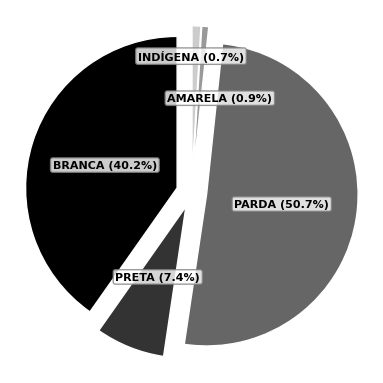

In [55]:
# Filter only elected officials
eleitos = inc4[inc4['ELEITO'] == 1]

# Define the racial categories
race_columns = ['BRANCA', 'PRETA', 'PARDA', 'INDÍGENA', 'AMARELA']

# Sum the total count for each race category among elected officials
race_counts = {}
for race in race_columns:
    if race in eleitos.columns:
        race_counts[race] = eleitos[race].sum()
    else:
        print(f"Warning: Column '{race}' not found in dataframe. Setting count to 0.")
        race_counts[race] = 0

# Convert to pandas Series
race_counts = pd.Series(race_counts)

# Ensure all categories have at least a small value to appear in the chart
for race in race_columns:
    if race_counts.get(race, 0) == 0:
        print(f"Setting minimum value for {race} to ensure it appears in the chart")
        race_counts[race] = 0.001

# Calculate percentages
race_percentages = race_counts / race_counts.sum() * 100

# Create custom labels with category name and percentage
custom_labels = [f"{race} ({percentage:.1f}%)" for race, percentage in zip(race_counts.index, race_percentages)]

# Define a grayscale color palette
grayscale = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC'][:len(race_counts)]

# Set figure size (10cm width in inches)
fig = plt.figure(figsize=(10/2.54, 10/2.54))
ax = fig.add_subplot(111)

# Create the pie chart with customized slice separation
explode_values = [0.1] * len(race_counts)

# Create the pie chart
wedges, _ = ax.pie(
    race_percentages,
    labels=None,
    startangle=90,
    colors=grayscale,
    explode=explode_values,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Add annotations manually with custom positions
for i, wedge in enumerate(wedges):
    angle = np.deg2rad((wedge.theta1 + wedge.theta2) / 2)
    radius = 0.6
    
    # Custom positioning
    if race_counts.index[i] == 'INDÍGENA':
        radius = 0.75  # Move further out
        angle += np.deg2rad(5)  # Slight angle adjustment
        y_offset = 0.15  # Additional upward shift
    elif race_counts.index[i] == 'AMARELA':
        radius = 0.65
        angle += np.deg2rad(-15)
        y_offset = 0
    else:
        y_offset = 0
    
    # Convert polar to cartesian with vertical adjustment
    x = radius * np.cos(angle)
    y = radius * np.sin(angle) + y_offset
    
    ax.annotate(
        custom_labels[i],
        xy=(x, y),
        xycoords='data',
        ha='center',
        va='center',
        fontsize=8,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.8)
    )

# Ensure the pie chart is circular
ax.axis('equal')
plt.tight_layout()

# Save the figures
plt.savefig(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico1.png", 
            dpi=1200, 
            bbox_inches='tight')
plt.savefig(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico1.svg", 
            format='svg',
            bbox_inches='tight')

plt.show()

# Save data
data_export = pd.DataFrame({
    'Race': race_counts.index,
    'Count': race_counts.values,
    'Percentage': race_percentages.values
})
data_export.to_csv(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico1.csv", index=False)

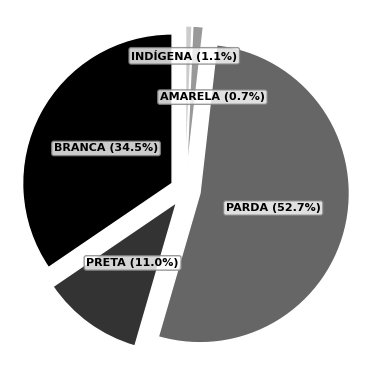


Data source:
Dataframe: inc4 (all candidates)

Race counts among all candidates:
BRANCA      3253.0
PRETA       1036.0
PARDA       4966.0
INDÍGENA     106.0
AMARELA       64.0
dtype: float64

Race percentages among all candidates:
BRANCA      34.514589
PRETA       10.992042
PARDA       52.689655
INDÍGENA     1.124668
AMARELA      0.679045
dtype: float64


In [56]:
# Use all candidates (not filtering for elected)
candidates = inc4.copy()

# Define the racial categories
race_columns = ['BRANCA', 'PRETA', 'PARDA', 'INDÍGENA', 'AMARELA']

# Sum the total count for each race category among all candidates
race_counts = {}
for race in race_columns:
    if race in candidates.columns:
        race_counts[race] = candidates[race].sum()
    else:
        print(f"Warning: Column '{race}' not found in dataframe. Setting count to 0.")
        race_counts[race] = 0

# Convert to pandas Series
race_counts = pd.Series(race_counts)

# Ensure all categories have at least a small value to appear in the chart
for race in race_columns:
    if race_counts.get(race, 0) == 0:
        print(f"Setting minimum value for {race} to ensure it appears in the chart")
        race_counts[race] = 0.001

# Calculate percentages
race_percentages = race_counts / race_counts.sum() * 100

# Create custom labels with category name and percentage
custom_labels = [f"{race} ({percentage:.1f}%)" for race, percentage in zip(race_counts.index, race_percentages)]

# Define a grayscale color palette
grayscale = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC'][:len(race_counts)]

# Convert 10 cm to inches (1 inch = 2.54 cm)
figsize_cm = 10
figsize_inches = figsize_cm / 2.54

# Create figure and axis with 10cm size
plt.figure(figsize=(figsize_inches, figsize_inches))

# Create the pie chart with customized slice separation
explode_values = [0.1] * len(race_counts)

# Create the pie chart without labels first
wedges, _ = plt.pie(
    race_percentages,
    labels=None,
    startangle=90,
    colors=grayscale,
    explode=explode_values,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Add annotations manually with custom positions
for i, wedge in enumerate(wedges):
    angle = np.deg2rad((wedge.theta1 + wedge.theta2) / 2)
    radius = 0.6
    
    # Custom positioning
    if race_counts.index[i] == 'INDÍGENA':
        radius = 0.75  # Move further out
        angle += np.deg2rad(5)  # Slight angle adjustment
        y_offset = 0.15  # Additional upward shift
    elif race_counts.index[i] == 'AMARELA':
        radius = 0.65
        angle += np.deg2rad(-15)
        y_offset = 0
    else:
        y_offset = 0
    
    # Convert polar to cartesian with vertical adjustment
    x = radius * np.cos(angle)
    y = radius * np.sin(angle) + y_offset
    
    plt.annotate(
        custom_labels[i],
        xy=(x, y),
        xycoords='data',
        ha='center',
        va='center',
        fontsize=8,  # Reduced font size for smaller figure
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc='white', ec="gray", alpha=0.8)
    )

# Ensure the pie chart looks circular
plt.axis('equal')
plt.tight_layout(pad=1.5)

# Save the figures
plt.savefig(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico2.png", dpi=1200, bbox_inches='tight')
plt.savefig(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico2.svg", format='svg', bbox_inches='tight')

plt.show()

# Print and save data
print("\nData source:")
print(f"Dataframe: inc4 (all candidates)")
print("\nRace counts among all candidates:")
print(race_counts)
print("\nRace percentages among all candidates:")
print(race_percentages)

data_export = pd.DataFrame({
    'Race': race_counts.index,
    'Count': race_counts.values,
    'Percentage': race_percentages.values
})
data_export.to_csv(r"C:\Users\daves\OneDrive\Pessoal\Artigo\TRE\Artigo\Gráfico2.csv", index=False)

In [57]:
print(inc4.columns)

Index(['NR_TURNO', 'SG_UE', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO_cand', 'NM_CANDIDATO_cand', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO',
       ...
       'CD_RGINT', 'NM_RGINT', 'CD_UF', 'NM_UF', 'CD_REGIAO', 'NM_REGIAO',
       'CD_CONCURB', 'NM_CONCURB', 'AREA_KM2', 'geometry'],
      dtype='object', length=136)


Bivariate Moran's I for BRANCA and ELEITO:
I value: -0.0407
p-value: 0.2200
--------------------------------------------------


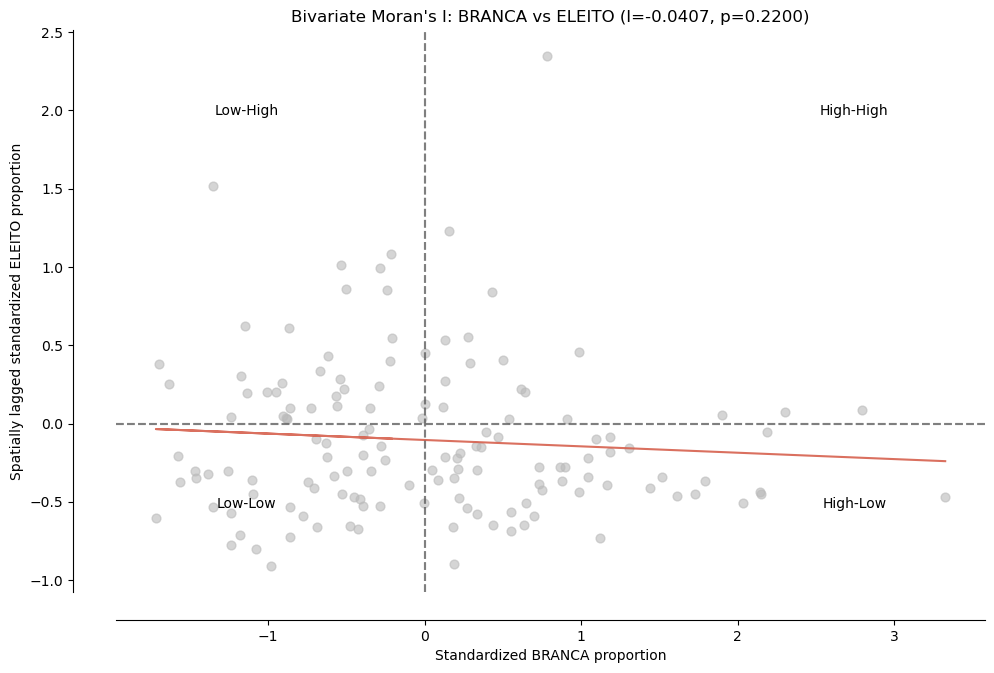

Bivariate Moran's I for PARDA and ELEITO:
I value: 0.0466
p-value: 0.1580
--------------------------------------------------


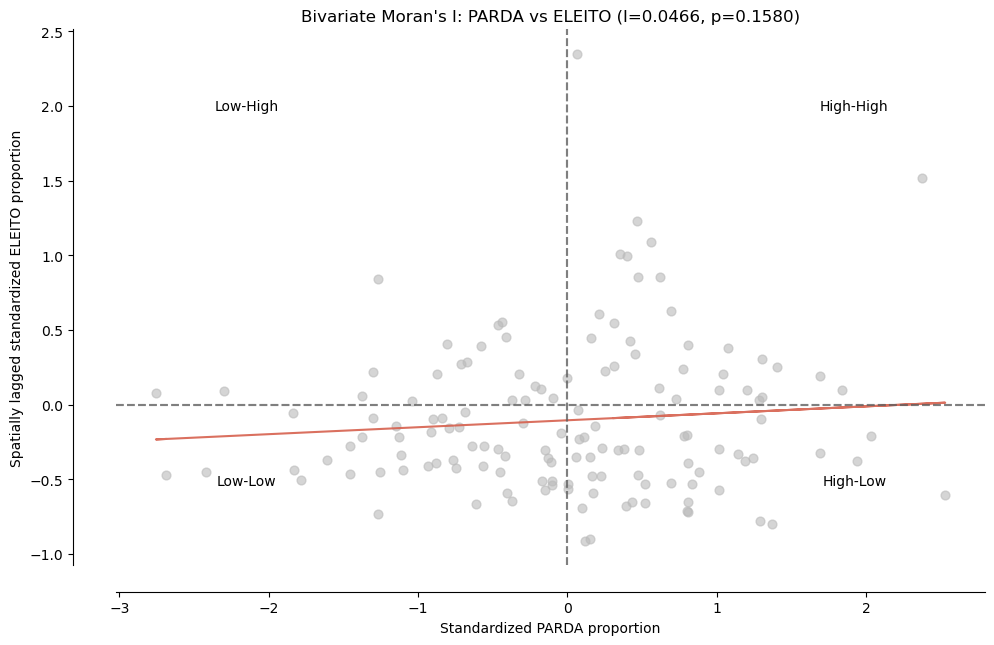

Bivariate Moran's I for PRETA and ELEITO:
I value: -0.0070
p-value: 0.4470
--------------------------------------------------


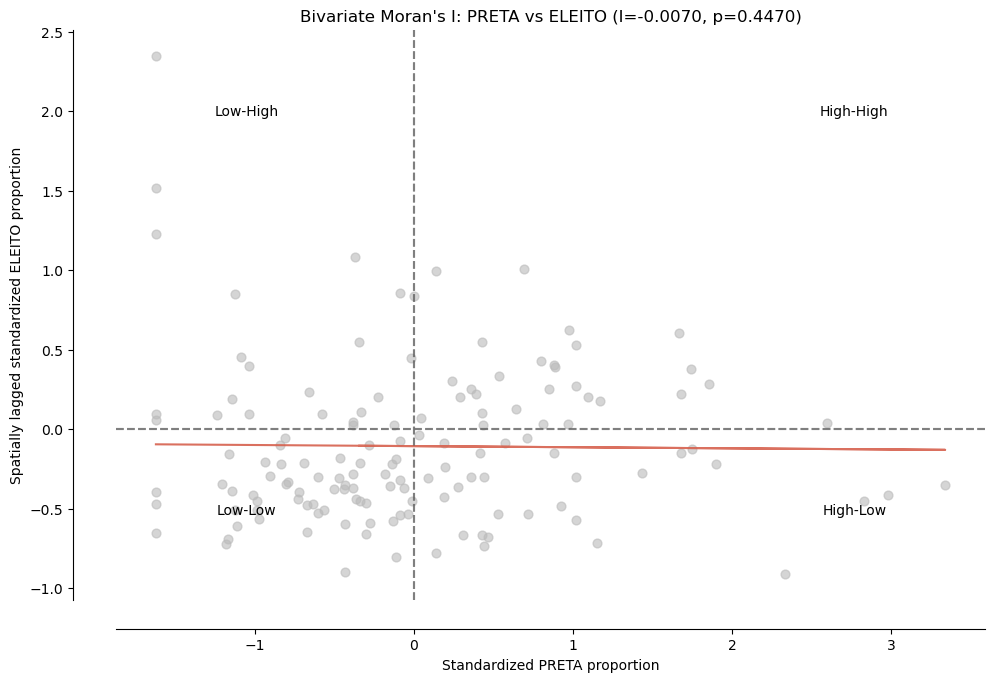

Bivariate Moran's I for INDÍGENA and ELEITO:
I value: -0.0139
p-value: 0.3910
--------------------------------------------------


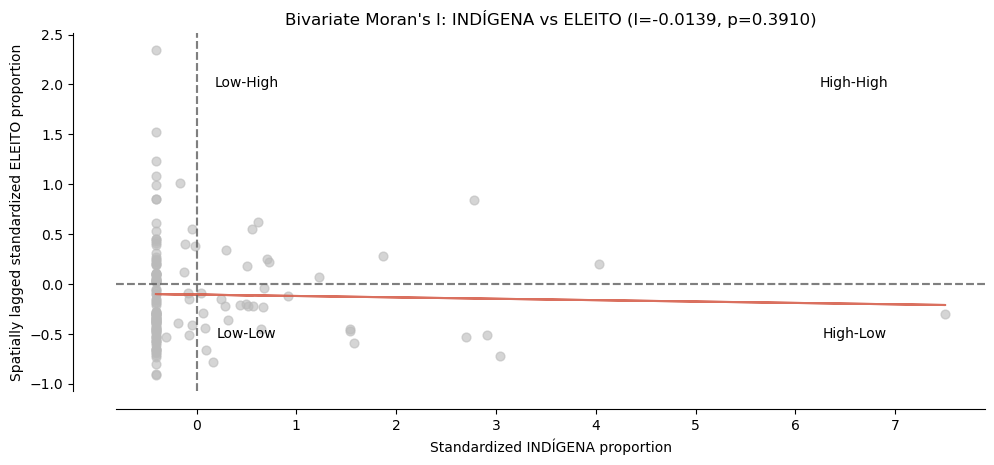

Bivariate Moran's I for AMARELA and ELEITO:
I value: 0.0382
p-value: 0.1580
--------------------------------------------------


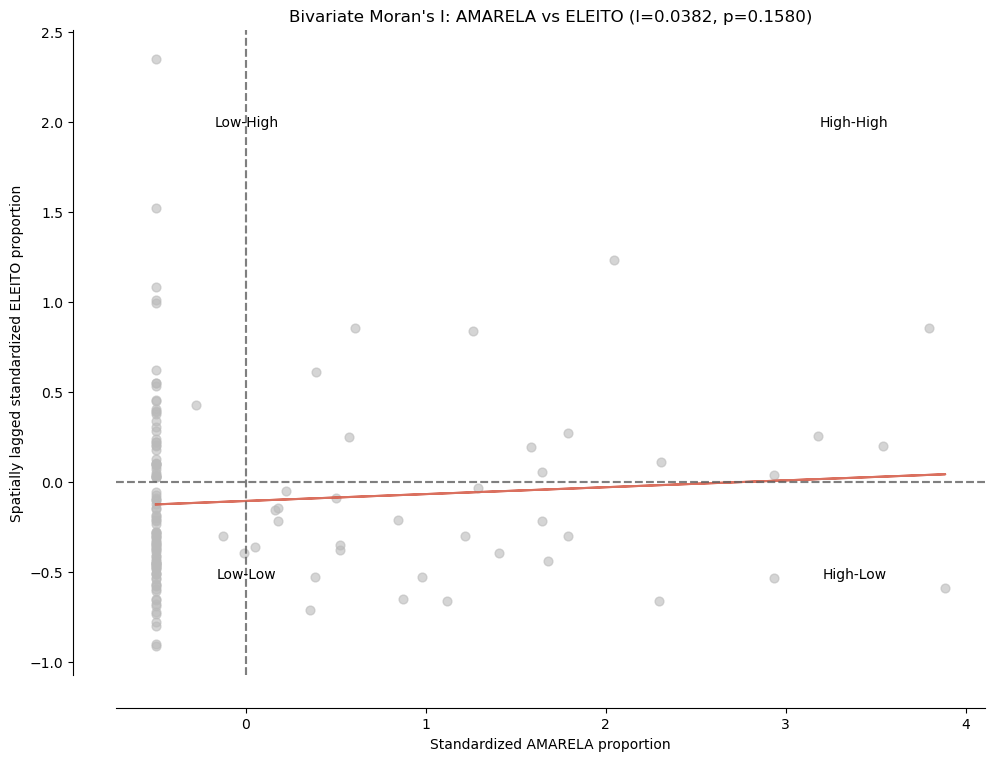

Bivariate Moran's I for FEMININO and ELEITO:
I value: -0.0072
p-value: 0.4010
--------------------------------------------------


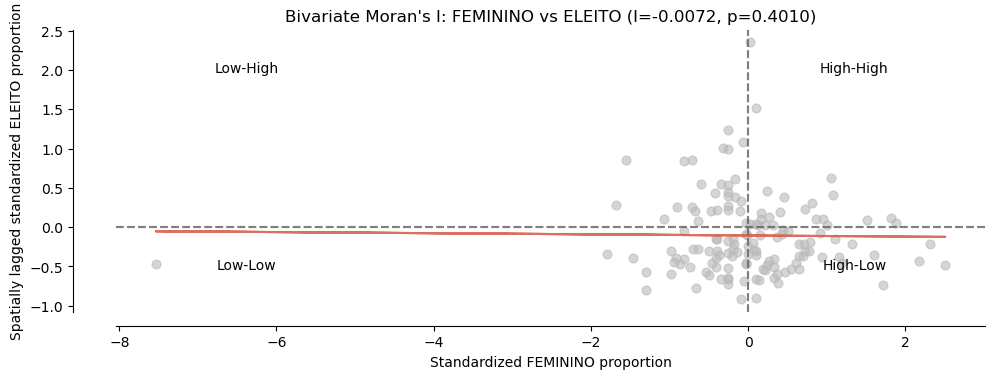

Bivariate Moran's I for MASCULINO and ELEITO:
I value: 0.0072
p-value: 0.4240
--------------------------------------------------


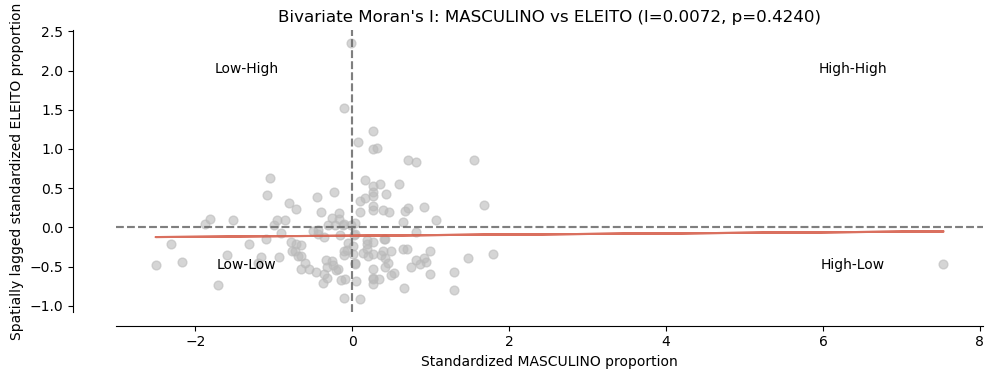

In [58]:
# List of race variables to test against ELEITO
race_variables = ['BRANCA', 'PARDA', 'PRETA', 'INDÍGENA', 'AMARELA', 'FEMININO', 'MASCULINO']

# Create a dictionary to store results
bivariate_results = {}

for race in race_variables:
    # Group by municipality and calculate mean of race dummy and ELEITO
    agg_data = inc4.groupby('NM_MUN')[[race, 'ELEITO']].mean()
    
    # Only keep municipalities that are in our weights matrix
    agg_data = agg_data.loc[W.index]
    
    # Run bivariate Moran's I
    moran_bv = Moran_BV(agg_data[race], agg_data['ELEITO'], queen)
    
    # Store results
    bivariate_results[race] = {
        'moran_bv': moran_bv.I,
        'p_value': moran_bv.p_sim,
        'race_values': agg_data[race],
        'eleito_values': agg_data['ELEITO']
    }
    
    # Print results
    print(f"Bivariate Moran's I for {race} and ELEITO:")
    print(f"I value: {moran_bv.I:.4f}")
    print(f"p-value: {moran_bv.p_sim:.4f}")
    print("-" * 50)
    
    # Create a new figure with explicit size
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use moran_scatterplot correctly
    moran_scatterplot(moran_bv, ax=ax)
    
    # Add more descriptive labels and title
    ax.set_title(f"Bivariate Moran's I: {race} vs ELEITO (I={moran_bv.I:.4f}, p={moran_bv.p_sim:.4f})")
    ax.set_xlabel(f"Standardized {race} proportion")
    ax.set_ylabel("Spatially lagged standardized ELEITO proportion")
    
    # Add a horizontal and vertical line to divide the quadrants
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.6)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.6)
    
    # Add quadrant labels
    ax.text(0.85, 0.85, "High-High", transform=ax.transAxes, ha='center')
    ax.text(0.15, 0.85, "Low-High", transform=ax.transAxes, ha='center')
    ax.text(0.85, 0.15, "High-Low", transform=ax.transAxes, ha='center')
    ax.text(0.15, 0.15, "Low-Low", transform=ax.transAxes, ha='center')
    
    # Make sure the plot gets displayed
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    fig.savefig(f"bivariate_moran_{race}_ELEITO.png", dpi=300, bbox_inches='tight')

### For this reason, there is no spatial autocorrelation

# Evaluating the refined model

## Oversampling

In [59]:
# Define features and target for Model 5
features5 = ['FUNDO ESPECIAL', 'OUTROS RECURSOS', 
             'BRANCA', 'AMARELA', 'PARDA', 
             'FEMININO', 'GOVERNADOR', 'PRESIDENTE', 'REELEIÇÃO',
             'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO FUNDAMENTAL INCOMPLETO','ENSINO MÉDIO COMPLETO',
             'ENSINO MÉDIO INCOMPLETO', 'LÊ E ESCREVE', 'SUPERIOR INCOMPLETO',
             'NÃO MAIS CASADO', 'SOLTEIRO(A)',
             'LOG_EDUCAÇÃO', 'LOG_SAUDE_ASSIST_SOCIAL']
target5 = 'ELEITO'

# Run the oversampling function for Model 5
def model5_oversample(data, features, target):
    """
    Perform logistic regression with oversampling techniques on Model 5.

    Parameters:
    - data: DataFrame containing the dataset.
    - features: List of independent variables (features).
    - target: String name of the dependent variable (target).

    Returns:
    - results: Dictionary containing evaluation metrics for each oversampling technique.
    """
    print("=" * 80)
    print("Model 5 with Oversampling")
    print("=" * 80)

    # 1. Select independent variables (features) and dependent variable (target)
    X = data[features]
    y = data[target]

    # Add a constant for the intercept term
    X = sm.add_constant(X)

    # 2. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 3. Define function to evaluate model
    def evaluate_model(X_train, y_train, X_test, y_test, oversampler=None):
        if oversampler:
            X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train, y_train

        # Train the logistic regression model
        model = sm.Logit(y_train_resampled, X_train_resampled)
        result = model.fit(disp=0)

        # Make predictions on the test set
        y_pred = result.predict(X_test)
        y_pred_class = (y_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_class)
        auc_roc = roc_auc_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred_class)
        class_report = classification_report(y_test, y_pred_class, output_dict=True)
        aic = result.aic
        bic = result.bic
        pseudo_r_squared = result.prsquared

        return {
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'AIC': aic,
            'BIC': bic,
            'Pseudo R-squared': pseudo_r_squared,
            'Confusion Matrix': conf_matrix,
            'Classification Report': pd.DataFrame(class_report).transpose(),
            'Model': result  # Return the model for coefficient analysis
        }

    # 4. Define oversampling techniques
    oversamplers = {
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'SVMSMOTE': SVMSMOTE(random_state=42)
    }

    # Also include the original model without oversampling for comparison
    oversamplers['No Oversampling'] = None

    # 5. Evaluate the model with each oversampling technique
    results = {}
    for name, oversampler in oversamplers.items():
        print(f"Evaluating with {name}...")
        results[name] = evaluate_model(X_train, y_train, X_test, y_test, oversampler)

    # 6. Print results for each oversampling technique
    for name, result in results.items():
        print("=" * 80)
        print(f"Results for {name}")
        print("=" * 80)
        print(f"Accuracy: {result['Accuracy']:.4f}")
        print(f"AUC-ROC: {result['AUC-ROC']:.4f}")
        print(f"AIC: {result['AIC']:.4f}")
        print(f"BIC: {result['BIC']:.4f}")
        print(f"Pseudo R-squared: {result['Pseudo R-squared']:.4f}")
        print("\nConfusion Matrix:")
        print(result['Confusion Matrix'])
        print("\nClassification Report:")
        print(result['Classification Report'])
        
        # Print coefficients
        print("\nCoefficients:")
        print(result['Model'].summary().tables[1])
        print("=" * 80)

    return results

# Compute original Model 5 metrics for comparison
X5 = inc3[features5]
y5 = inc3[target5]
X5 = sm.add_constant(X5)
model5 = sm.Logit(y5, X5)
result5 = model5.fit()
y5_pred = result5.predict(X5)
y5_pred_class = (y5_pred > 0.5).astype(int)
accuracy5 = accuracy_score(y5, y5_pred_class)

# Call the oversampling function for Model 5
results5 = model5_oversample(inc3, features5, target5)

# Compare the performance of the original model vs. the oversampled models
print("=" * 80)
print("Performance Comparison")
print("=" * 80)
print("Original Model 5 Accuracy:", accuracy5)
print("Original Model 5 AIC:", result5.aic)
print("Original Model 5 BIC:", result5.bic)
print("Original Model 5 Pseudo R-squared:", result5.prsquared)

print("\nOversampling Results:")
for name, result in results5.items():
    print(f"{name} - Accuracy: {result['Accuracy']:.4f}, AUC-ROC: {result['AUC-ROC']:.4f}")

Optimization terminated successfully.
         Current function value: 0.348807
         Iterations 7
Model 5 with Oversampling
Evaluating with SMOTE...
Evaluating with ADASYN...
Evaluating with SVMSMOTE...
Evaluating with No Oversampling...
Results for SMOTE
Accuracy: 0.7341
AUC-ROC: 0.7984
AIC: 11992.8817
BIC: 12139.3658
Pseudo R-squared: 0.2306

Confusion Matrix:
[[1802  627]
 [ 134  299]]

Classification Report:
              precision    recall  f1-score      support
0.0            0.930785  0.741869  0.825659  2429.000000
1.0            0.322894  0.690531  0.440029   433.000000
accuracy       0.734102  0.734102  0.734102     0.734102
macro avg      0.626840  0.716200  0.632844  2862.000000
weighted avg   0.838816  0.734102  0.767316  2862.000000

Coefficients:
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                      